In [1]:
!pip install gymnasium
!pip install matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 6.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

In [3]:
def relu(q):
  return q*(q>0)

def relu_deriv(q):
  #return 1 if q>0, 0 otherwise
  return 1*(q>0)

def boltz(y,T):
  ym=np.max(y)
  #apply boltz
  y_exp=np.exp((y-ym)/T) #stabalize with max of z
  prob_actions=y_exp/np.sum(y_exp)
  return prob_actions

#implemetns 2 layer NN
class NeuralNet:
  #T: Temperature for Boltz
  #gamma: discounts for rewards
  def __init__(self,num_states,num_actions,T,gamma,learning_rate=3e-4,num_hidden=128):
    self.learning_rate=learning_rate
    self.d=num_states #encodings for input dimension
    self.m=num_hidden #encoding for hidden layer dimension
    self.c=num_actions #encoding for output layer dimension, num of actions
    self.T=T
    self.gamma=gamma

    #init weights
    #init parameters of each action independently & randomly according to normal distribution
    #reference: What Matters In On-Policy Reinforcement Learning? A Large-Scale Empirical Study
    self.V=np.random.normal(0,0.5,(self.d,self.m))
    self.W=np.random.normal(0,0.5,(self.m,self.c))/100

  def next_action(self,s):
    res=s
    res=np.dot(res,self.V) #Vs
    res=relu(res) #relu(Vs)
    res=np.dot(res,self.W) #W(relu(Vs))
    prob_actions=boltz(res,self.T) #Boltz(Relu(Vs))

    highest_prob_action = np.random.choice(self.c, p=np.squeeze(prob_actions))
    return highest_prob_action

  #update the net after entire episode finishes
  #walk through each time step & update self.V and self.W at each time step
  def update(self,all_states, all_rewards):
    total_timesteps=len(all_rewards) #total time step

    discounted_rewards=[]
    #compute discounted rewards for all timesteps
    for t in range(total_timesteps):
      Gt=0 #rewards starting at ts=t
      pw=0
      for r in all_rewards[t:]:
        Gt+=self.gamma**pw*r
        pw+=1
      discounted_rewards.append(Gt)

    discounted_rewards=np.array(discounted_rewards)
    # normalize discounted rewards
    discounted_rewards=(discounted_rewards-np.mean(discounted_rewards))/(np.std(discounted_rewards)+1e-9)

    #ensure we're not applying our weights while they are updating
    tmp_V=np.copy(self.V)
    tmp_W=np.copy(self.W)

    for i in range(total_timesteps):
      #do forward pass to colllect all data
      s_i=all_states[i] #d-dim
      q=np.dot(s_i,tmp_V) #m-dim
      z=relu(q) #m-dim
      y=np.dot(z,tmp_W) #c-dim
      A=boltz(y,self.T) #C dimensional, A1...Ac = pi(action_1), pi(action_2)...pi(action_c)

      dw=np.zeros((self.m,self.c)) #gradient of self.W

      #iterate through each col of dw & set dw
      for j in range(self.c):
        dw[:,j]=(1-A[j])*z #m-dim
      dw=dw

      #iterate through each cell of dv & set dv
      dv=np.zeros((self.d,self.m))
      pref=(1-A) #c-dim
      for dv_i in range(self.d):
        for dv_j in range(self.m):
          dv[dv_i,dv_j]=np.dot(pref,self.W[dv_j,:])*relu_deriv(q[dv_j])*s_i[dv_i]

      #update our parameters self.W and self.V
      self.W=self.W+self.learning_rate*discounted_rewards[i]*dw
      self.V=self.V + self.learning_rate*discounted_rewards[i]*dv




In [4]:
class Reinforce:
  def __init__(self,policy_net):
    self.policy_net=policy_net

  def train(self,num_episodes, env):
    episodes_timesteps=[]
    for i in range(num_episodes):
      rewards=[]
      all_states=[] #record all states. Used to compute gradient
      terminated=False
      truncated=False

      action=env.action_space.sample()
      observation, info = env.reset()
      all_states.append(observation)
      #generate a full episode and collect all rewards
      ts=0
      while(True):
        ts+=1
        next_state, reward, terminated,truncated,info = env.step(action) #act
        if (terminated or truncated):
          self.policy_net.update(all_states,rewards)
          break
        rewards.append(reward)
        all_states.append(next_state)
        action =self.policy_net.next_action(next_state) #select next action using our policy
      env.reset()
      episodes_timesteps.append(ts)
    return episodes_timesteps


In [5]:
#different set up for decaying T.
#delete this?
#implemetns 2 layer NN
class NeuralNet_decay_T:
  #T: Temperature for Boltz
  #gamma: discounts for rewards
  def __init__(self,num_states,num_actions,gamma,learning_rate=3e-4,num_hidden=128):
    self.learning_rate=learning_rate
    self.d=num_states #encodings for input dimension
    self.m=num_hidden #encoding for hidden layer dimension
    self.c=num_actions #encoding for output layer dimension, num of actions
    self.gamma=gamma
    #init parameters of each action independently & randomly according to normal distribution
    #use mean=0, std=0.5
    #reference: What Matters In On-Policy Reinforcement Learning? A Large-Scale Empirical Study
    self.V=np.random.normal(0,0.5,(self.d,self.m))
    self.W=np.random.normal(0,0.5,(self.m,self.c))/100

  def next_action(self,s,temperature):
    res=s
    res=np.dot(res,self.V) #Vs
    res=relu(res) #relu(Vs)
    res=np.dot(res,self.W) #W(relu(Vs))
    prob_actions=boltz(res,temperature) #Boltz(Relu(Vs))
    highest_prob_action = np.random.choice(self.c, p=np.squeeze(prob_actions))
    return highest_prob_action     # get action with highest estimated average reward with random tie-breaking

  def update(self,all_states, all_rewards,temp):
    total_timesteps=len(all_rewards) #total time step
    discounted_rewards=[] #store discounted rewards for all timesteps

    for t in range(total_timesteps):
      Gt=0 #rewards starting at ts=t
      pw=0
      for r in all_rewards[t:]:
        Gt+=self.gamma**pw*r
        pw+=1
      discounted_rewards.append(Gt)
    discounted_rewards=np.array(discounted_rewards)
    # normalize discounted rewards
    discounted_rewards=(discounted_rewards-np.mean(discounted_rewards))/(np.std(discounted_rewards)+1e-9)

    tmp_V=np.copy(self.V)
    tmp_W=np.copy(self.W)

    #iterate through state
    for i in range(total_timesteps):
      #do forward pass to colllect all data
      s_i=all_states[i] #d-dim
      q=np.dot(s_i,tmp_V) #m-dim.
      z=relu(q) #m-dim
      y=np.dot(z,tmp_W) #c-dim
      A=boltz(y,temp) #C dimensional, A1...Ac = pi(action_1), pi(action_2)...pi(action_c)
      dw=np.zeros((self.m,self.c)) #gradient of self.W
      #iterate through each col of dw & set dw
      for j in range(self.c):
        dw[:,j]=(1-A[j])*z #m-dim
      dv=np.zeros((self.d,self.m))
      pref=(1-A) #c-dim
      for dv_i in range(self.d):
        for dv_j in range(self.m):
          dv[dv_i,dv_j]=np.dot(pref,self.W[dv_j,:])*relu_deriv(q[dv_j])*s_i[dv_i]

      self.W=self.W+self.learning_rate*discounted_rewards[i]*dw
      self.V=self.V + self.learning_rate*discounted_rewards[i]*dv

In [6]:
class Reinforce_decay_T:
  def __init__(self,policy_net_decay_T,T,T_decay_factor=1):
    self.policy_net_decay_T=policy_net_decay_T
    self.T=T
    self.T_decay_factor=T_decay_factor

  def train(self,num_episodes, env):
    episodes_timesteps=[]
    for i in range(num_episodes):
      rewards=[]
      all_states=[] #record all states. Used to compute gradient
      terminated=False
      truncated=False
      action=env.action_space.sample() #first action is random
      observation, info = env.reset()
      all_states.append(observation) #append initial state ? (not sure about dimension)
      ts=0
      while(True):
        #print(action)
        ts+=1
        next_state, reward, terminated,truncated,info = env.step(action) #act
        if (terminated or truncated):
          self.policy_net_decay_T.update(all_states,rewards,self.T)
          break
        rewards.append(reward) #record r_t
        all_states.append(next_state) #record s_t
        all_temperatures.append(tmp_T)
        action =self.policy_net_decay_T.next_action(next_state,self.T) #select next action using our policy
      self.T*=self.T_decay_factor
      env.reset() #finished an episode
      episodes_timesteps.append(ts)
    return episodes_timesteps


#CartPole-V1

In [ ]:
env=gym.make('CartPole-v1')
observation, info = env.reset()

In [ ]:
env=gym.make('CartPole-v1')
observation, info = env.reset()

num_episodes=1000
episodes_ts=[]
different_T=[0.01,0.1,0.2,0.5,0.99]
for i in range(5):
  policy_net=NeuralNet(env.observation_space.shape[0],env.action_space.n,different_T[i], gamma=0.7)
  reinforce=Reinforce(policy_net=policy_net)
  episodes_ts.append(np.array(reinforce.train(num_episodes,env)))
episodes_ts=np.array(episodes_ts)
#episodes_ts=np.mean(episodes_ts,axis=0)

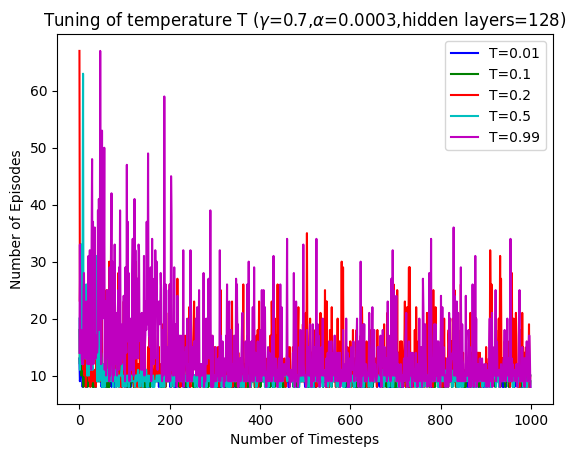

In [ ]:
#Decide which Temperature T to use
ts=np.arange(num_episodes)
colors=['b','g','r','c','m']
for i in range(len(different_T)):
  plt.plot(ts,episodes_ts[i],colors[i],label='T='+str(different_T[i]))
plt.xlabel("Number of Timesteps")
plt.ylabel("Number of Episodes")
plt.title(r"Tuning of temperature T ($\gamma$=0.7,$\alpha$=0.0003,hidden layers=128)")
plt.legend()

In [ ]:
#use T=0.99
num_episodes=1000
episodes_ts=[]
different_gamma=[0.1,0.2,0.5,0.7,0.99]
for i in range(5):
  policy_net=NeuralNet(env.observation_space.shape[0],env.action_space.n,T=0.99, gamma=different_gamma[i])
  reinforce=Reinforce(policy_net=policy_net)
  episodes_ts.append(np.array(reinforce.train(num_episodes,env)))
episodes_ts=np.array(episodes_ts)
#episodes_ts=np.mean(episodes_ts,axis=0)

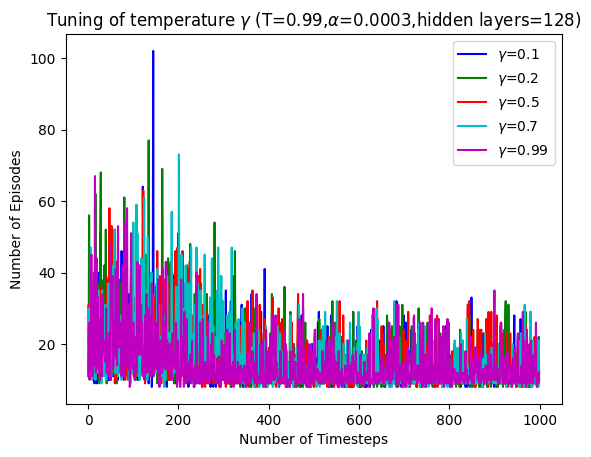

In [ ]:
#Decide which gamma to use
ts=np.arange(num_episodes)
colors=['b','g','r','c','m']
for i in range(len(different_gamma)):
  plt.plot(ts[:1000],episodes_ts[i,:1000],colors[i],label='$\gamma$='+str(different_gamma[i]))
plt.legend()
plt.xlabel("Number of Timesteps")
plt.ylabel("Number of Episodes")
plt.title(r"Tuning of temperature $\gamma$ (T=0.99,$\alpha$=0.0003,hidden layers=128)")
plt.legend()

In [ ]:
#exmaine the optimal parameter combination for gamma and T
num_episodes=800
episodes_ts=[]
different_gamma=[0.1,0.2,0.5,0.7,0.99]
different_T=[0.01,0.1,0.2,0.5,0.99]

for i in range(len(different_gamma)):
  for j in range(len(different_T)):
    policy_net=NeuralNet(env.observation_space.shape[0],env.action_space.n,different_T[j], gamma=different_gamma[i])
    reinforce=Reinforce(policy_net=policy_net)
    episodes_ts.append(np.array(reinforce.train(num_episodes,env)))
episodes_ts=np.array(episodes_ts) #will contain 25 indepent trials (one for each combination), each containing 800 episodes


Text(0, 0.5, 'Number of Timesteps')

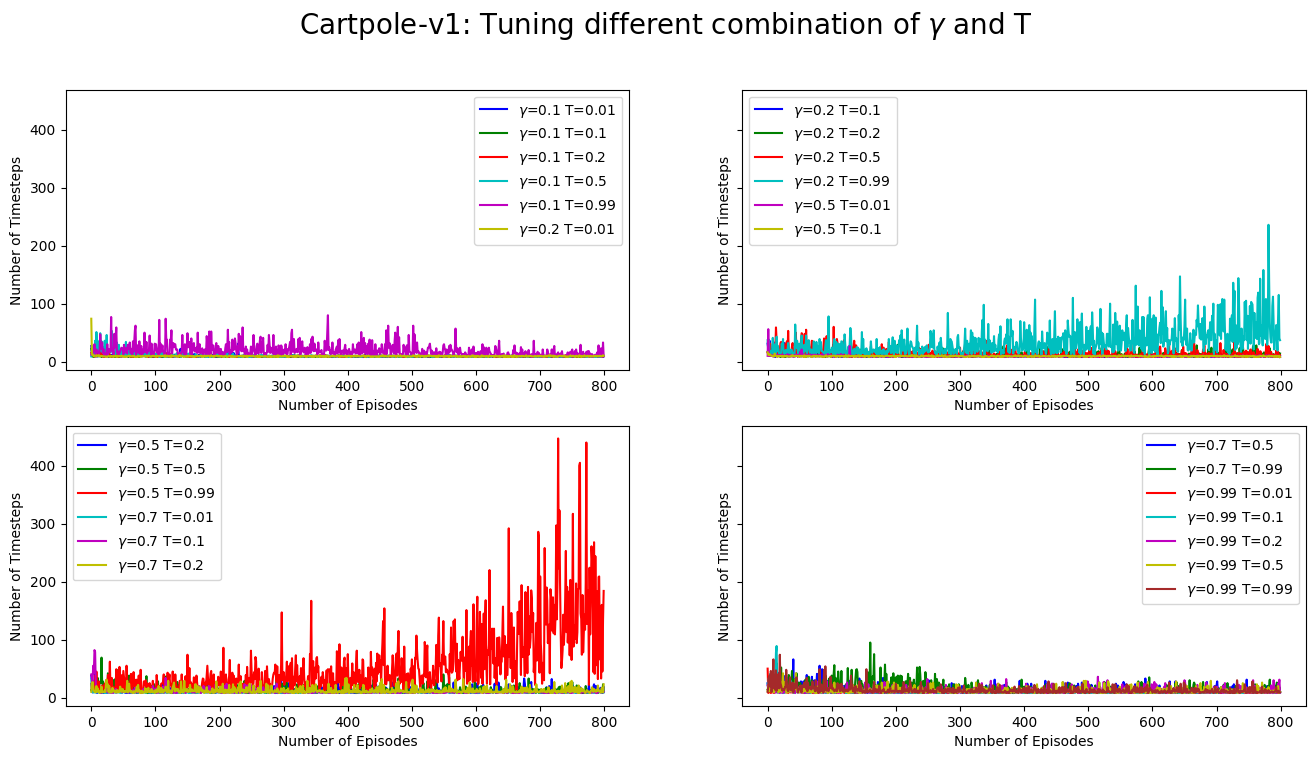

In [ ]:

ts=np.arange(num_episodes)
colors=['b','g','r','c','m','y','brown']
fig, axes=plt.subplots(nrows=2,ncols=2,sharey='all',figsize=(16,8))

fig.suptitle(r'Cartpole-v1: Tuning different combination of $\gamma$ and T',fontsize=20)
axes[0,0].plot(ts,episodes_ts[0],colors[0],label=r'$\gamma$='+str(different_gamma[0])+" T="+str(different_T[0]))
axes[0,0].plot(ts,episodes_ts[1],colors[1],label=r'$\gamma$='+str(different_gamma[0])+" T="+str(different_T[1]))
axes[0,0].plot(ts,episodes_ts[2],colors[2],label=r'$\gamma$='+str(different_gamma[0])+" T="+str(different_T[2]))
axes[0,0].plot(ts,episodes_ts[3],colors[3],label=r'$\gamma$='+str(different_gamma[0])+" T="+str(different_T[3]))
axes[0,0].plot(ts,episodes_ts[4],colors[4],label=r'$\gamma$='+str(different_gamma[0])+" T="+str(different_T[4]))
axes[0,0].plot(ts,episodes_ts[5],colors[5],label=r'$\gamma$='+str(different_gamma[1])+" T="+str(different_T[0]))
axes[0,0].legend()
axes[0,0].set_xlabel("Number of Episodes")
axes[0,0].set_ylabel("Number of Timesteps")


axes[0,1].plot(ts,episodes_ts[6],colors[0],label=r'$\gamma$='+str(different_gamma[1])+" T="+str(different_T[1]))
axes[0,1].plot(ts,episodes_ts[7],colors[1],label=r'$\gamma$='+str(different_gamma[1])+" T="+str(different_T[2]))
axes[0,1].plot(ts,episodes_ts[8],colors[2],label=r'$\gamma$='+str(different_gamma[1])+" T="+str(different_T[3]))
axes[0,1].plot(ts,episodes_ts[9],colors[3],label=r'$\gamma$='+str(different_gamma[1])+" T="+str(different_T[4]))
axes[0,1].plot(ts,episodes_ts[10],colors[4],label=r'$\gamma$='+str(different_gamma[2])+" T="+str(different_T[0]))
axes[0,1].plot(ts,episodes_ts[11],colors[5],label=r'$\gamma$='+str(different_gamma[2])+" T="+str(different_T[1]))
axes[0,1].legend()
axes[0,1].set_xlabel("Number of Episodes")
axes[0,1].set_ylabel("Number of Timesteps")

axes[1,0].plot(ts,episodes_ts[12],colors[0],label=r'$\gamma$='+str(different_gamma[2])+" T="+str(different_T[2]))
axes[1,0].plot(ts,episodes_ts[13],colors[1],label=r'$\gamma$='+str(different_gamma[2])+" T="+str(different_T[3]))
axes[1,0].plot(ts,episodes_ts[14],colors[2],label=r'$\gamma$='+str(different_gamma[2])+" T="+str(different_T[4]))
axes[1,0].plot(ts,episodes_ts[15],colors[3],label=r'$\gamma$='+str(different_gamma[3])+" T="+str(different_T[0]))
axes[1,0].plot(ts,episodes_ts[16],colors[4],label=r'$\gamma$='+str(different_gamma[3])+" T="+str(different_T[1]))
axes[1,0].plot(ts,episodes_ts[17],colors[5],label=r'$\gamma$='+str(different_gamma[3])+" T="+str(different_T[2]))
axes[1,0].legend()
axes[1,0].set_xlabel("Number of Episodes")
axes[1,0].set_ylabel("Number of Timesteps")

axes[1,1].plot(ts,episodes_ts[18],colors[0],label=r'$\gamma$='+str(different_gamma[3])+" T="+str(different_T[3]))
axes[1,1].plot(ts,episodes_ts[19],colors[1],label=r'$\gamma$='+str(different_gamma[3])+" T="+str(different_T[4]))
axes[1,1].plot(ts,episodes_ts[20],colors[2],label=r'$\gamma$='+str(different_gamma[4])+" T="+str(different_T[0]))
axes[1,1].plot(ts,episodes_ts[21],colors[3],label=r'$\gamma$='+str(different_gamma[4])+" T="+str(different_T[1]))
axes[1,1].plot(ts,episodes_ts[22],colors[4],label=r'$\gamma$='+str(different_gamma[4])+" T="+str(different_T[2]))
axes[1,1].plot(ts,episodes_ts[23],colors[5],label=r'$\gamma$='+str(different_gamma[4])+" T="+str(different_T[3]))
axes[1,1].plot(ts,episodes_ts[24],colors[6],label=r'$\gamma$='+str(different_gamma[4])+" T="+str(different_T[4]))
axes[1,1].legend()
axes[1,1].set_xlabel("Number of Episodes")
axes[1,1].set_ylabel("Number of Timesteps")

#gamma=0.5 and T=0.99


In [ ]:
#use T=0.99, gamma=0.5
num_episodes=1000
episodes_ts=[]
different_lr=[1e-4,2e-4,3e-4,4e-4,5e-4]
for i in range(5):
  policy_net=NeuralNet(env.observation_space.shape[0],env.action_space.n,T=0.99, gamma=0.7,learning_rate=different_lr[i])
  reinforce=Reinforce(policy_net=policy_net)
  episodes_ts.append(np.array(reinforce.train(num_episodes,env)))
episodes_ts=np.array(episodes_ts)

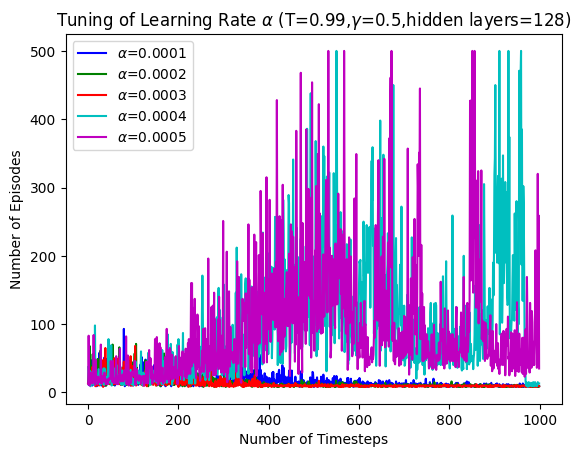

In [ ]:
ts=np.arange(num_episodes)
colors=['b','g','r','c','m']
for i in range(len(different_lr)):
  plt.plot(ts,episodes_ts[i],colors[i],label=r'$\alpha$='+str(different_lr[i]))
plt.legend()
plt.xlabel("Number of Timesteps")
plt.ylabel("Number of Episodes")
plt.title(r"Tuning of Learning Rate $\alpha$ (T=0.99,$\gamma$=0.5,hidden layers=128)")
plt.legend()

##CartPole: Fixed T

In [ ]:
num_episodes=1000
episodes_ts=[] #50*1000

#Set T=0.99, run 50 trials
num_trials=50
for i in range(num_trials):
  #init a new policy NN every time
  policy_net=NeuralNet(env.observation_space.shape[0],env.action_space.n,T=0.99, gamma=0.5,learning_rate=4e-4)
  reinforce=Reinforce(policy_net=policy_net)
  episodes_ts.append(np.array(reinforce.train(num_episodes,env)))
episodes_ts=np.array(episodes_ts)

Text(0.5, 1.0, 'CartPole-v1: Average Performance (over 50 runs) of fixed T=0.99')

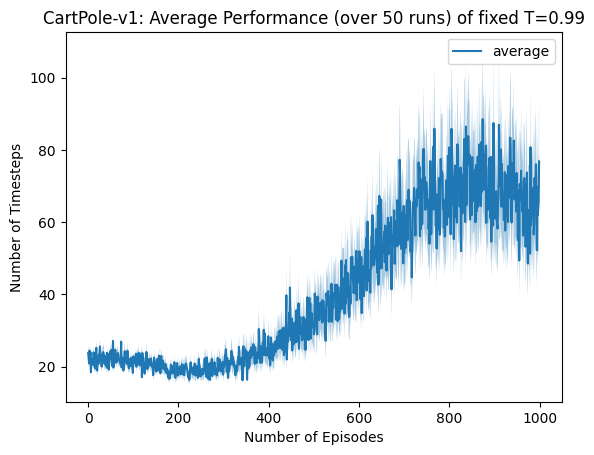

In [ ]:
#plot graph for fixed T
ts=np.arange(num_episodes)
avg_performance=np.mean(episodes_ts,axis=0) #averaged over all trials
std_over_trials=np.std(episodes_ts,axis=0)/np.sqrt(np.size(episodes_ts,axis=0))

plt.plot(ts,avg_performance,label='average')
performance_below=avg_performance-std_over_trials
performance_above=avg_performance+std_over_trials
plt.fill_between(range(0,num_episodes),performance_below,performance_above,alpha=0.4)
plt.legend()
plt.xlabel("Number of Episodes")
plt.ylabel("Number of Timesteps")
plt.title("CartPole-v1: Average Performance (over 50 runs) of fixed T="+str(0.99))

##CartPole: Decaying T

In [ ]:
#config2: decaying temperature T
#decays T with factor 0.99 every time step
num_episodes=1000
episodes_ts_decay_T=[] #50*1000

#2nd config: Set T=0.99, Decay factor=0.99, run 50 trials
num_trials=50
for i in range(num_trials):
  #init a new policy NN every time
  policy_net=NeuralNet_decay_T(env.observation_space.shape[0],env.action_space.n, gamma=0.5,learning_rate=4e-4)
  reinforce=Reinforce_decay_T(policy_net_decay_T=policy_net,T=0.99,T_decay_factor=0.99) #decay T by 0.99 every episode
  episodes_ts_decay_T.append(np.array(reinforce.train(num_episodes,env)))
episodes_ts_decay_T=np.array(episodes_ts_decay_T)


Text(0.5, 1.0, 'CartPole-v1: Average Performance (over 50 runs) of decaying T=0.99 with decay factor=0.99')

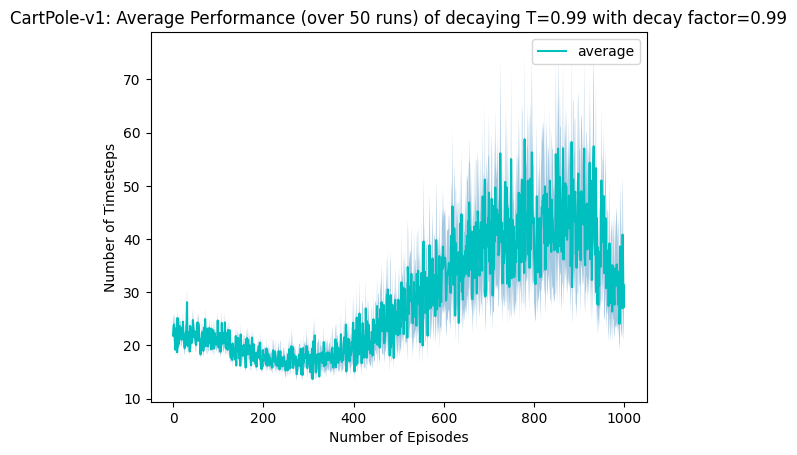

In [ ]:
#plot graph for config 2 (decaying T)
ts=np.arange(num_episodes)
avg_performance=np.mean(episodes_ts_decay_T,axis=0) #averaged over all trials
std_over_trials=np.std(episodes_ts_decay_T,axis=0)/np.sqrt(np.size(episodes_ts_decay_T,axis=0))

plt.plot(ts,avg_performance,'c',label='average')
performance_below=avg_performance-std_over_trials
performance_above=avg_performance+std_over_trials
plt.fill_between(range(0,num_episodes),performance_below,performance_above,alpha=0.4)
plt.legend()
plt.xlabel("Number of Episodes")
plt.ylabel("Number of Timesteps")
plt.title("CartPole-v1: Average Performance (over 50 runs) of decaying T=0.99"+" with decay factor=0.99")

#Mountain Car

In [7]:
#define different reward mechanism for mountainc car
class Reinforce_MC:
  def __init__(self,policy_net,max_timestep):
    self.policy_net=policy_net
    self.max_timestep=max_timestep

  def train(self,num_episodes, env,positive_reward_factor=1,negative_reward_factor=1,speed_factor=0):
    episodes_timesteps=[]
    rewards_timesteps=[]
    max_pos_timesteps=[]
    for i in range(num_episodes):
      print("episode: "+str(i))
      rewards=[]
      all_states=[] #record all states. Used to compute gradient
      terminated=False
      truncated=False
      action=env.action_space.sample()
      observation, info = env.reset()
      all_states.append(observation) #append initial state ? (not sure about dimension)

      ts=0
      max_pos=-0.4
      min_pos=-0.6
      total_reward=0
      while(True):
        ts+=1
        next_state, reward, terminated,truncated,info = env.step(action) #act
        #reached end of episode. Update policy
        if (terminated or ts>self.max_timestep):
          self.policy_net.update(all_states,rewards)
          break

        #Reward the agent everytime if made it pass its previous max position
        #Reward is porpotional to how far the agent is able to get
        #The amount of reward is parameterized by positive_reward_factor
        if next_state[0]>max_pos:
          reward+=positive_reward_factor*(1+(next_state[0]-(-0.4)))
          max_pos=next_state[0]

        #Similarily, reward the agent everytime if made it pass its previous min position
        #The amount of reward is parameterized by negative_reward_factor
        if next_state[0]<min_pos:
          reward+=negative_reward_factor*(0.5-0.6-next_state[0])
          min_pos=next_state[0]

        #Reward the agent based on its velocity
        #Incentivize agent to maximizes its velocity
        #Paramterized by speed_factor
        reward=reward+speed_factor*np.absolute(next_state[1])

        total_reward+=reward
        rewards.append(reward) #record reward at each timestep
        all_states.append(next_state) #record state at each timestep, used to compute gradient
        action =self.policy_net.next_action(next_state) #select next action using our policy
      env.reset() #finished an episode
      episodes_timesteps.append(ts)
      rewards_timesteps.append(total_reward)
      max_pos_timesteps.append(max_pos)

    return episodes_timesteps,rewards_timesteps,max_pos_timesteps



In [8]:
#slightly different implementation for decaying T
class Reinforce_MC_decay_T:
  def __init__(self,policy_net_decay_T,max_timestep,T,T_decay_factor=1):
    self.policy_net_decay_T=policy_net_decay_T
    self.T=T
    self.T_decay_factor=T_decay_factor
    self.max_timestep=max_timestep

  def train(self,num_episodes, env,positive_reward_factor=1,negative_reward_factor=1,speed_factor=0):
    #positive reward factor determines how much the reward is when the agent surpasses its previuos max position
    #negative reward determines how much the reward is when the agent surpasses its previuos min position
    episodes_timesteps=[]
    rewards_timesteps=[]
    max_pos_timesteps=[]
    for i in range(num_episodes):
      rewards=[]
      all_states=[] #record all states. Used to compute gradient
      all_temperatures=[]
      terminated=False
      truncated=False
      action=env.action_space.sample() #first action is random

      observation, info = env.reset()

      all_states.append(observation) #append initial state ? (not sure about dimension)
      ts=0
      max_pos=-0.4
      min_pos=-0.6
      total_reward=0
      while(True):
        ts+=1
        next_state, reward, terminated,truncated,info = env.step(action) #act
        if (terminated or ts>self.max_timestep):
          self.policy_net_decay_T.update(all_states,rewards,self.T)
          break

        #similar reward mechanism
        if next_state[0]>max_pos:
          #reward is proportional to the progress it made
          reward+=positive_reward_factor*(1+next_state[0]-(-0.4))
          max_pos=next_state[0]
        if next_state[0]<min_pos:
          reward+=negative_reward_factor*(0.5-0.6-next_state[0])
          min_pos=next_state[0]
        reward=reward+speed_factor*np.absolute(next_state[1])

        total_reward+=reward
        rewards.append(reward)
        all_states.append(next_state)
        action =self.policy_net_decay_T.next_action(next_state,self.T) #select next action using our policy
      self.T*=self.T_decay_factor #decay T after each episode
      env.reset()
      episodes_timesteps.append(ts)
      rewards_timesteps.append(total_reward)
      max_pos_timesteps.append(max_pos)
    return episodes_timesteps,rewards_timesteps,max_pos_timesteps


In [10]:
env=gym.make('MountainCar-v0')
observation, info = env.reset()

##Finding optimal combination of gamma and T

In [ ]:
#use pos reward factor=0.1, neg reward factor=10, speed factor=10,lr=1e-5
num_episodes=300
episodes_ts=[]
total_rw_ts=[] #total rewards for 9 independent runs
maxpos_ts=[] #max pos over 9 independent runs
different_gamma=[0.1,0.5,0.99]
different_T=[0.1,1,10]

for i in range(len(different_gamma)):
  for j in range(len(different_T)):
    policy_net_decay=NeuralNet_decay_T(env.observation_space.shape[0],env.action_space.n, gamma=different_gamma[i],learning_rate=1e-5)
    reinforce=Reinforce_MC_decay_T(policy_net_decay_T=policy_net_decay,max_timestep=1000,T=different_T[j],T_decay_factor=0.95)
    ts_per_episodes, total_rw_per_episode, maxpos_per_episodes=reinforce.train(num_episodes,env,positive_reward_factor=0.1,negative_reward_factor=10,speed_factor=10)
    episodes_ts.append(np.array(ts_per_episodes))
    total_rw_ts.append(np.array(total_rw_per_episode))
    maxpos_ts.append(np.array(maxpos_per_episodes))


episodes_ts=np.array(episodes_ts) #will contain 9 indepent trials (one for each combination), each containing 300 episodes
total_rw_ts=np.array(total_rw_ts)
maxpos_ts=np.array(maxpos_ts)

Text(0.5, 1.0, 'Max position of the car per each episodes')

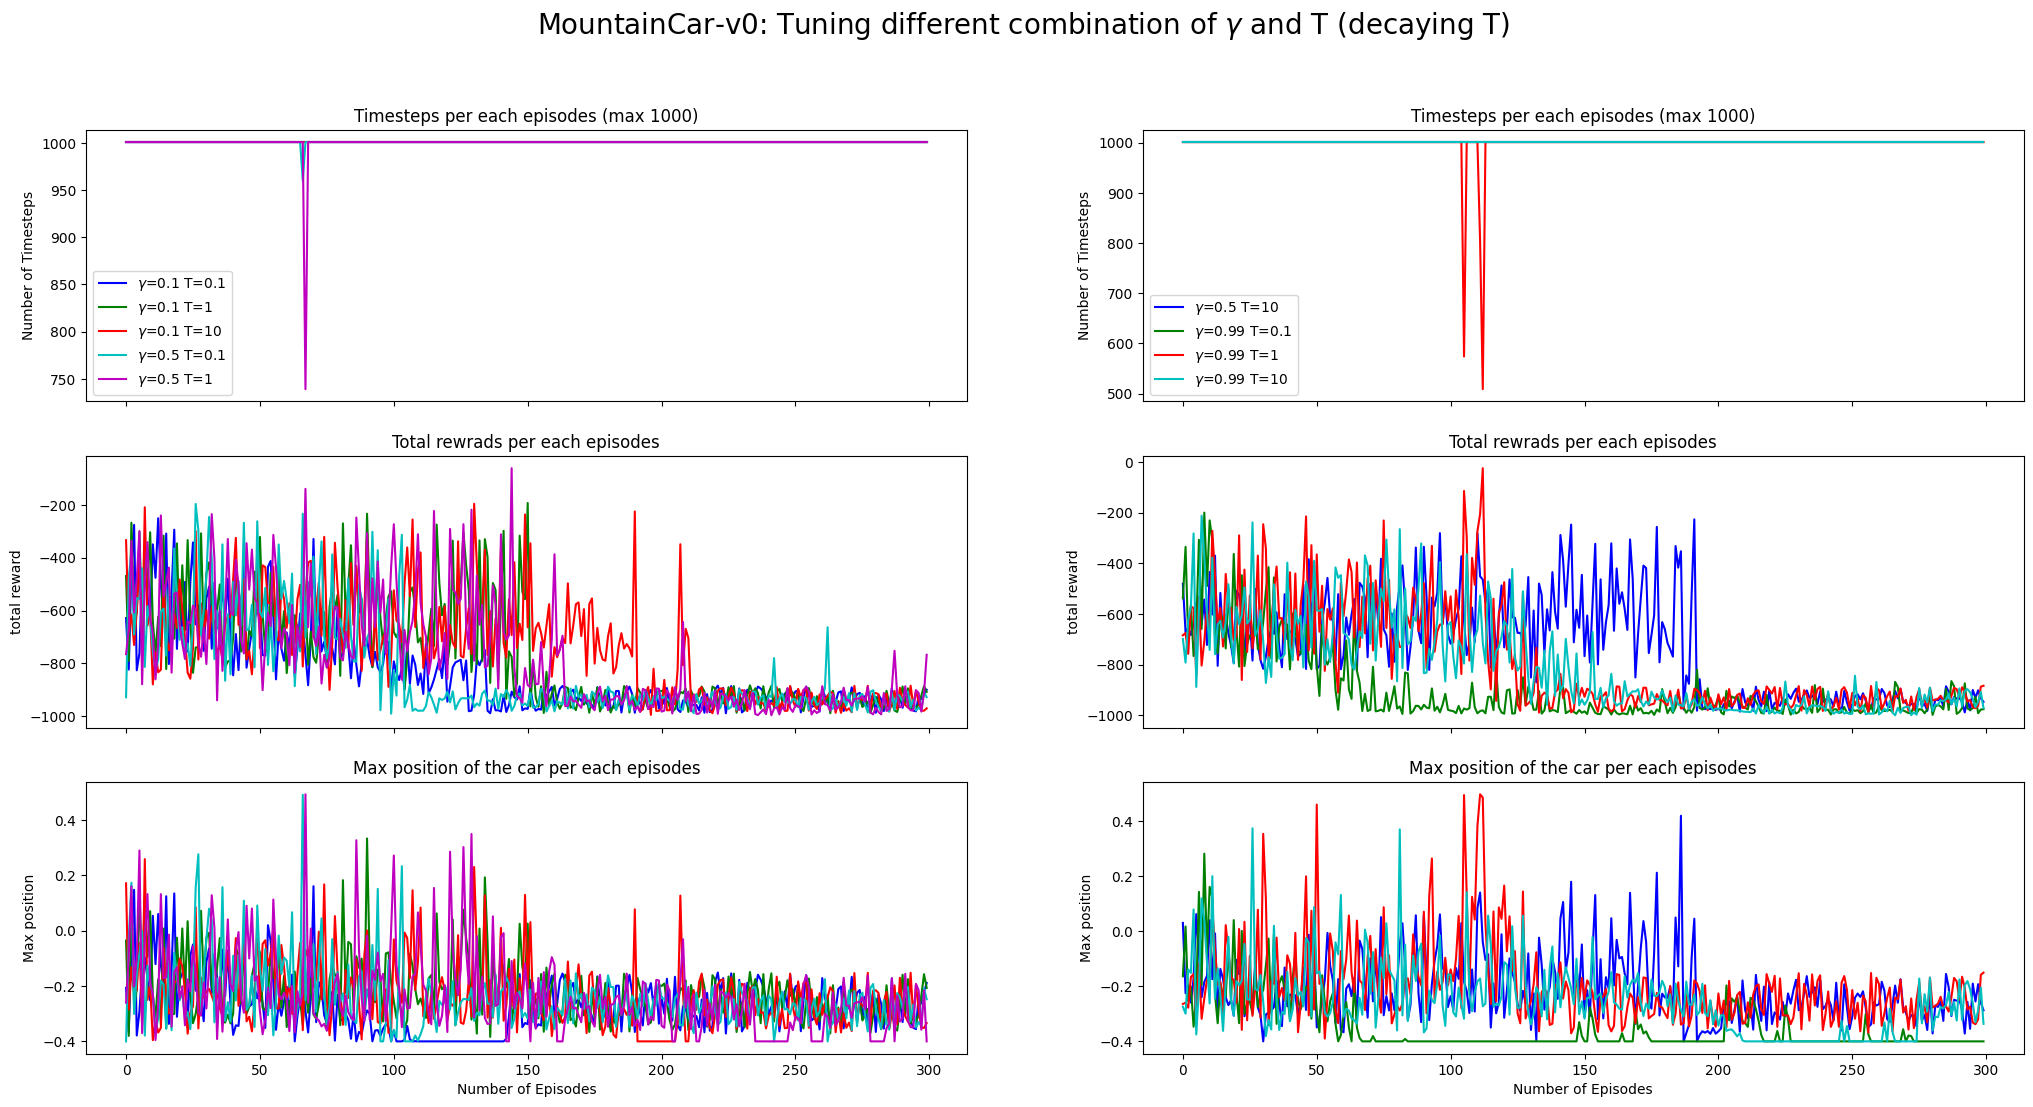

In [ ]:
#plot result
ts=np.arange(num_episodes)
colors=['b','g','r','c','m','y']
fig, axes=plt.subplots(nrows=3,ncols=2,sharex="all",figsize=(25,12))


line_no=0
for i in range(len(different_gamma)):
  for j in range(len(different_T)):
    axes[0][line_no//5].plot(ts,episodes_ts[line_no],colors[line_no%5],label=r'$\gamma$='+str(different_gamma[i])+" T="+str(different_T[j]))
    axes[1][line_no//5].plot(ts,total_rw_ts[line_no],colors[line_no%5],label=r'$\gamma$='+str(different_gamma[i])+" T="+str(different_T[j]))
    axes[2][line_no//5].plot(ts,maxpos_ts[line_no],colors[line_no%5],label=r'$\gamma$='+str(different_gamma[i])+" T="+str(different_T[j]))
    line_no+=1

fig.suptitle(r'MountainCar-v0: Tuning different combination of $\gamma$ and T (decaying T)',fontsize=20)

axes[0][0].set_ylabel("Number of Timesteps")
axes[0][0].set_title("Timesteps per each episodes (max 1000)")
axes[0][0].legend()

axes[1][0].set_ylabel("total reward")
axes[1][0].set_title("Total rewrads per each episodes")

axes[2][0].set_xlabel("Number of Episodes")
axes[2][0].set_ylabel("Max position")
axes[2][0].set_title("Max position of the car per each episodes")

axes[0][1].set_ylabel("Number of Timesteps")
axes[0][1].set_title("Timesteps per each episodes (max 1000)")
axes[0][1].legend()

axes[1][1].set_ylabel("total reward")
axes[1][1].set_title("Total rewrads per each episodes")

axes[2][1].set_xlabel("Number of Episodes")
axes[2][1].set_ylabel("Max position")
axes[2][1].set_title("Max position of the car per each episodes")



#gamma=0.5 and T=0.99


##Finding optimal combination of Postive & Negative reward factor

In [ ]:
#use gamma=0.5, Temperature=0.1
#test with different combination of positive & negative reward factor
num_episodes=300
episodes_ts=[]
total_rw_ts=[] #total rewards for 9 independent runs
maxpos_ts=[] #max pos over 9 independent runs
different_psf=[0.1,1,10]
different_nrf=[0.1,1,10]

for i in range(len(different_psf)):
  for j in range(len(different_nrf)):
    policy_net_decay=NeuralNet_decay_T(env.observation_space.shape[0],env.action_space.n,gamma=0.5)
    reinforce=Reinforce_MC_decay_T(policy_net_decay_T=policy_net_decay,max_timestep=1000,T=0.1,T_decay_factor=0.95)
    ts_per_episodes, total_rw_per_episode, maxpos_per_episodes=reinforce.train(num_episodes,env,positive_reward_factor=different_psf[i],negative_reward_factor=different_nrf[j],speed_factor=10)
    episodes_ts.append(np.array(ts_per_episodes))
    total_rw_ts.append(np.array(total_rw_per_episode))
    maxpos_ts.append(np.array(maxpos_per_episodes))


episodes_ts=np.array(episodes_ts) #will contain 9 indepent trials (one for each combination), each containing 300 episodes
total_rw_ts=np.array(total_rw_ts)
maxpos_ts=np.array(maxpos_ts)
#episodes_ts=np.mean(episodes_ts,axis=0)

Text(0.5, 1.0, 'Max position of the car per each episodes')

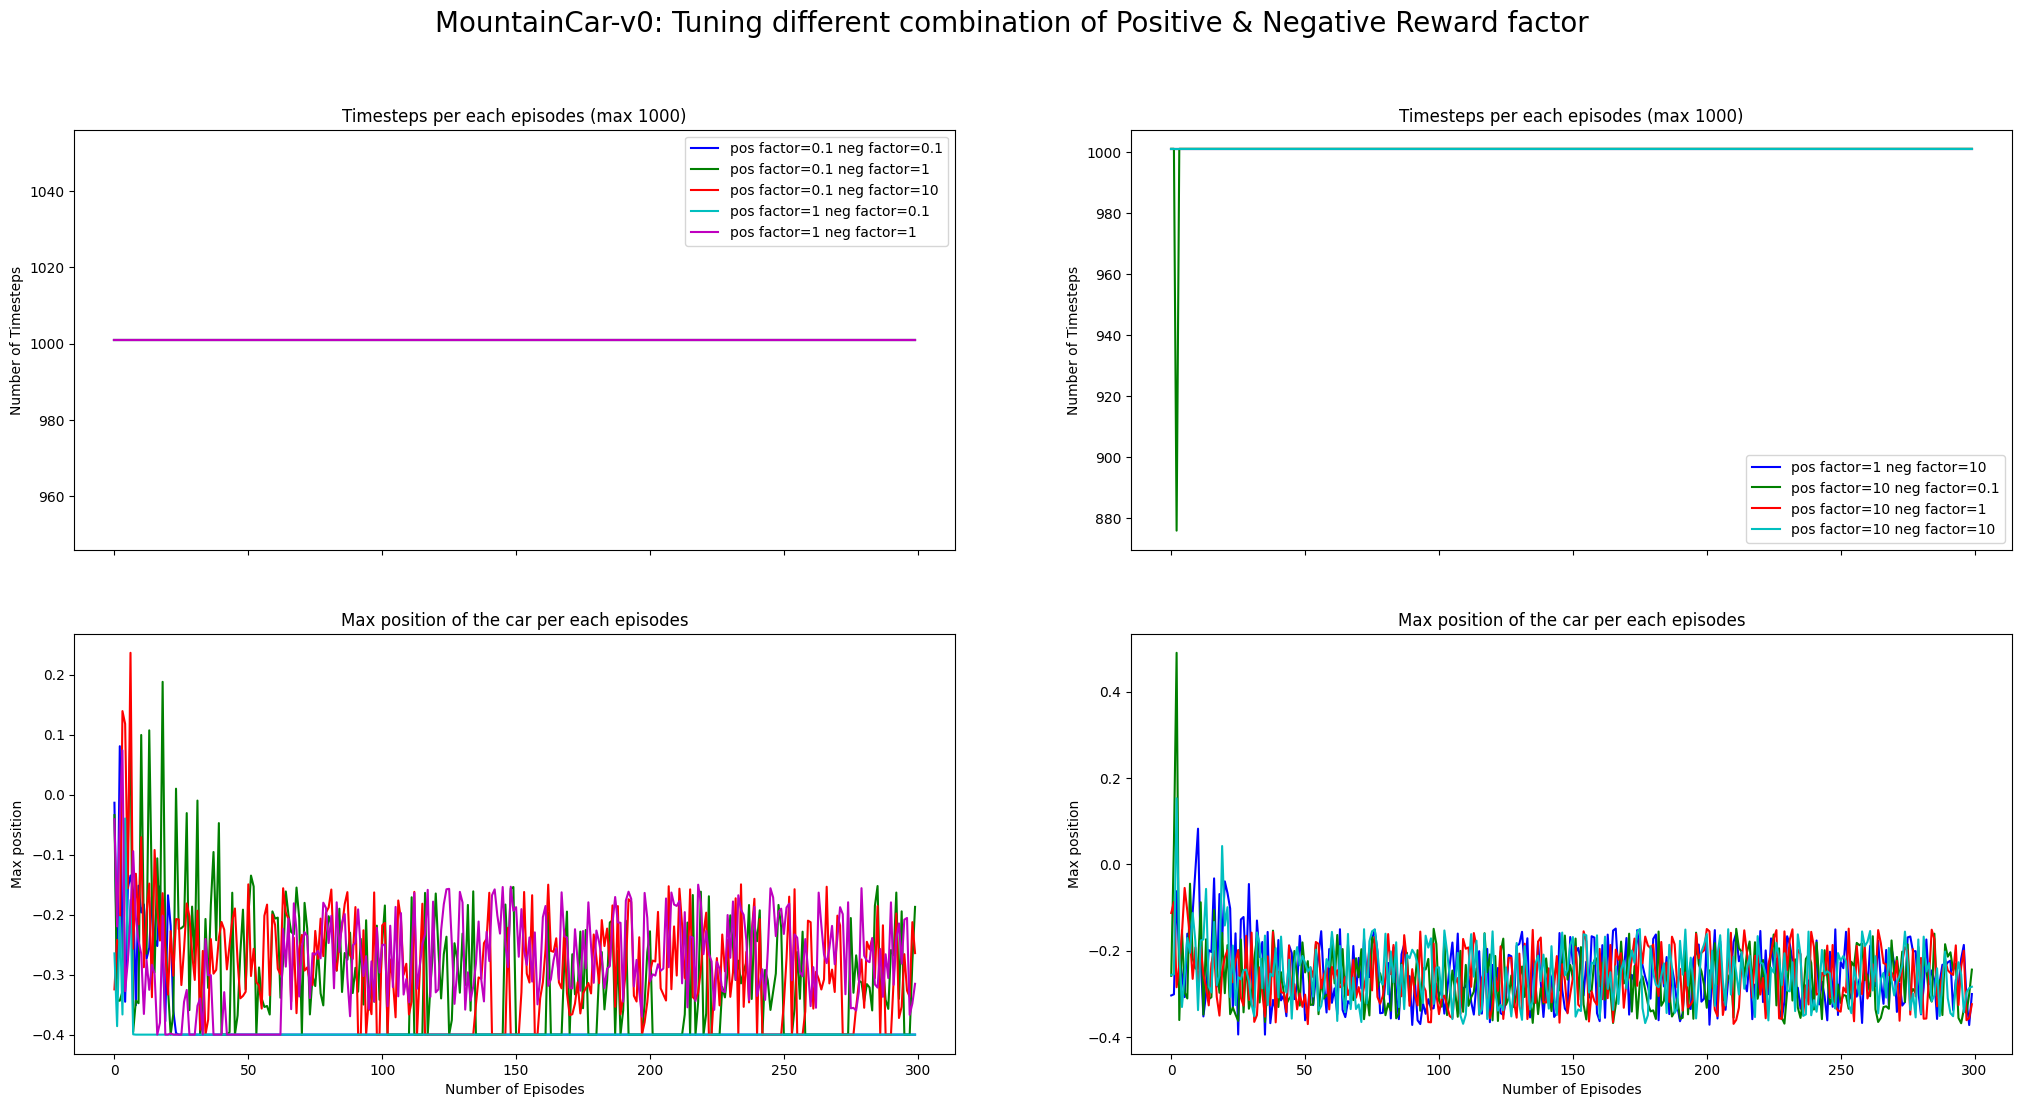

In [ ]:

ts=np.arange(num_episodes)
colors=['b','g','r','c','m','y']
fig, axes=plt.subplots(nrows=2,ncols=2,sharex="all",figsize=(25,12))

line_no=0
for i in range(len(different_psf)):
  for j in range(len(different_nrf)):
    axes[0][line_no//5].plot(ts,episodes_ts[line_no],colors[line_no%5],label='pos factor='+str(different_psf[i])+" neg factor="+str(different_nrf[j]))
    #axes[1][line_no//5].plot(ts,total_rw_ts[line_no],colors[line_no%5],label='pos factor='+str(different_psf[i])+" neg factor="+str(different_nrf[j]))
    axes[1][line_no//5].plot(ts,maxpos_ts[line_no],colors[line_no%5],label='pos factor='+str(different_psf[i])+" neg factor="+str(different_nrf[j]))
    line_no+=1

fig.suptitle(r'MountainCar-v0: Tuning different combination of Positive & Negative Reward factor',fontsize=20)

axes[0][0].set_ylabel("Number of Timesteps")
axes[0][0].set_title("Timesteps per each episodes (max 1000)")
axes[0][0].legend()

axes[1][0].set_xlabel("Number of Episodes")
axes[1][0].set_ylabel("Max position")
axes[1][0].set_title("Max position of the car per each episodes")


axes[0][1].set_ylabel("Number of Timesteps")
axes[0][1].set_title("Timesteps per each episodes (max 1000)")
axes[0][1].legend()


axes[1][1].set_xlabel("Number of Episodes")
axes[1][1].set_ylabel("Max position")
axes[1][1].set_title("Max position of the car per each episodes")



#gamma=0.5 and T=0.99

#pos reward factor=0.1, neg reward factor=10


##Finding optimal Learning Rate

In [ ]:
#tuning learning rate
#use gamma=0.5, Temperature=0.1, pos reward factor=0.1, neg reward factor=10
num_episodes=300
episodes_ts=[]
total_rw_ts=[]
maxpos_ts=[]

different_lr=[1e-5,1e-4,1e-3,1e-2]
for i in range(len(different_lr)):
  policy_net_decay=NeuralNet_decay_T(env.observation_space.shape[0],env.action_space.n,gamma=0.5,learning_rate=different_lr[i])
  reinforce=Reinforce_MC_decay_T(policy_net_decay_T=policy_net_decay,max_timestep=1000,T=0.1,T_decay_factor=0.95)
  ts_per_episodes, total_rw_per_episode, maxpos_per_episodes=reinforce.train(num_episodes,env,positive_reward_factor=0.1,negative_reward_factor=10)
  episodes_ts.append(np.array(ts_per_episodes))
  total_rw_ts.append(np.array(total_rw_per_episode))
  maxpos_ts.append(np.array(maxpos_per_episodes))

episodes_ts=np.array(episodes_ts)
total_rw_ts=np.array(total_rw_ts)
maxpos_ts=np.array(maxpos_ts)
#episodes_ts=np.mean(episodes_ts,axis=0)

Text(0.5, 1.0, 'Max position of the car per each episodes')

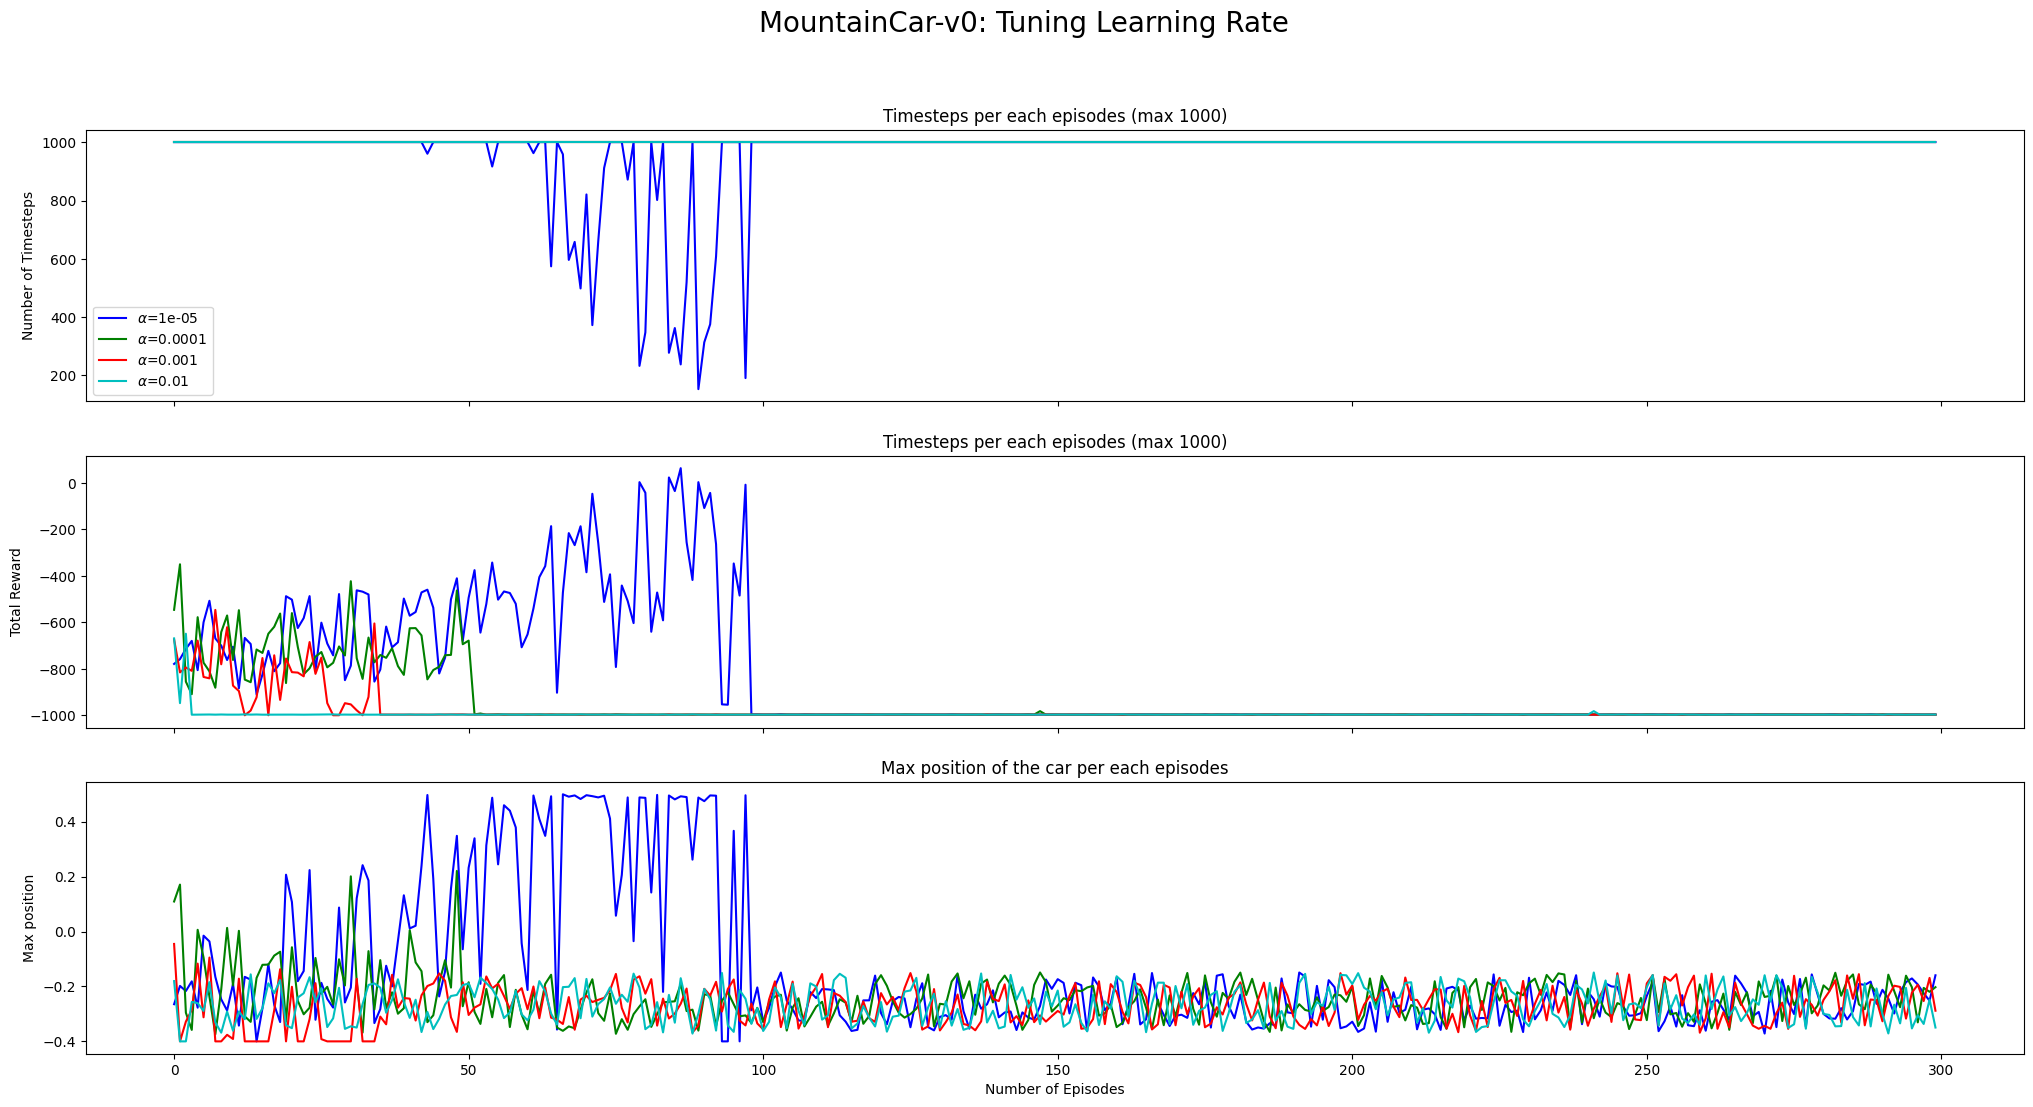

In [ ]:
ts=np.arange(num_episodes)
colors=['b','g','r','c','m']
fig, axes=plt.subplots(nrows=3,ncols=1,sharex="all",figsize=(25,12))

for i in range(len(different_lr)):
  axes[0].plot(ts,episodes_ts[i],colors[i],label=r'$\alpha$='+str(different_lr[i]))

for i in range(len(different_lr)):
  axes[1].plot(ts,total_rw_ts[i],colors[i],label=r'$\alpha$='+str(different_lr[i]))

for i in range(len(different_lr)):
  axes[2].plot(ts,maxpos_ts[i],colors[i],label=r'$\alpha$='+str(different_lr[i]))

fig.suptitle(r'MountainCar-v0: Tuning Learning Rate',fontsize=20)

axes[0].set_ylabel("Number of Timesteps")
axes[0].set_title("Timesteps per each episodes (max 1000)")
axes[0].legend()

axes[1].set_ylabel("Total Reward")
axes[1].set_title("Timesteps per each episodes (max 1000)")


axes[2].set_xlabel("Number of Episodes")
axes[2].set_ylabel("Max position")
axes[2].set_title("Max position of the car per each episodes")


##Finding the Optimal Speed Factor

In [ ]:
#use lr=1e-5, gamma=0.5, Temperature=0.1, pos reward factor=0.1, neg reward factor=10
num_episodes=300
episodes_ts=[]
total_rw_ts=[]
maxpos_ts=[]

different_speed_factor=[0,0.1,1,10]
for i in range(len(different_speed_factor)):
  policy_net_decay=NeuralNet_decay_T(env.observation_space.shape[0],env.action_space.n,gamma=0.5,learning_rate=1e-5)
  reinforce=Reinforce_MC_decay_T(policy_net_decay_T=policy_net_decay,max_timestep=1000,T=0.1,T_decay_factor=0.95)
  ts_per_episodes, total_rw_per_episode, maxpos_per_episodes=reinforce.train(num_episodes,env,positive_reward_factor=0.1,negative_reward_factor=10,speed_factor=different_speed_factor[i])
  episodes_ts.append(np.array(ts_per_episodes))
  total_rw_ts.append(np.array(total_rw_per_episode))
  maxpos_ts.append(np.array(maxpos_per_episodes))

episodes_ts=np.array(episodes_ts)
total_rw_ts=np.array(total_rw_ts)
maxpos_ts=np.array(maxpos_ts)
#episodes_ts=np.mean(episodes_ts,axis=0)


Text(0.5, 1.0, 'Max position of the car per each episodes')

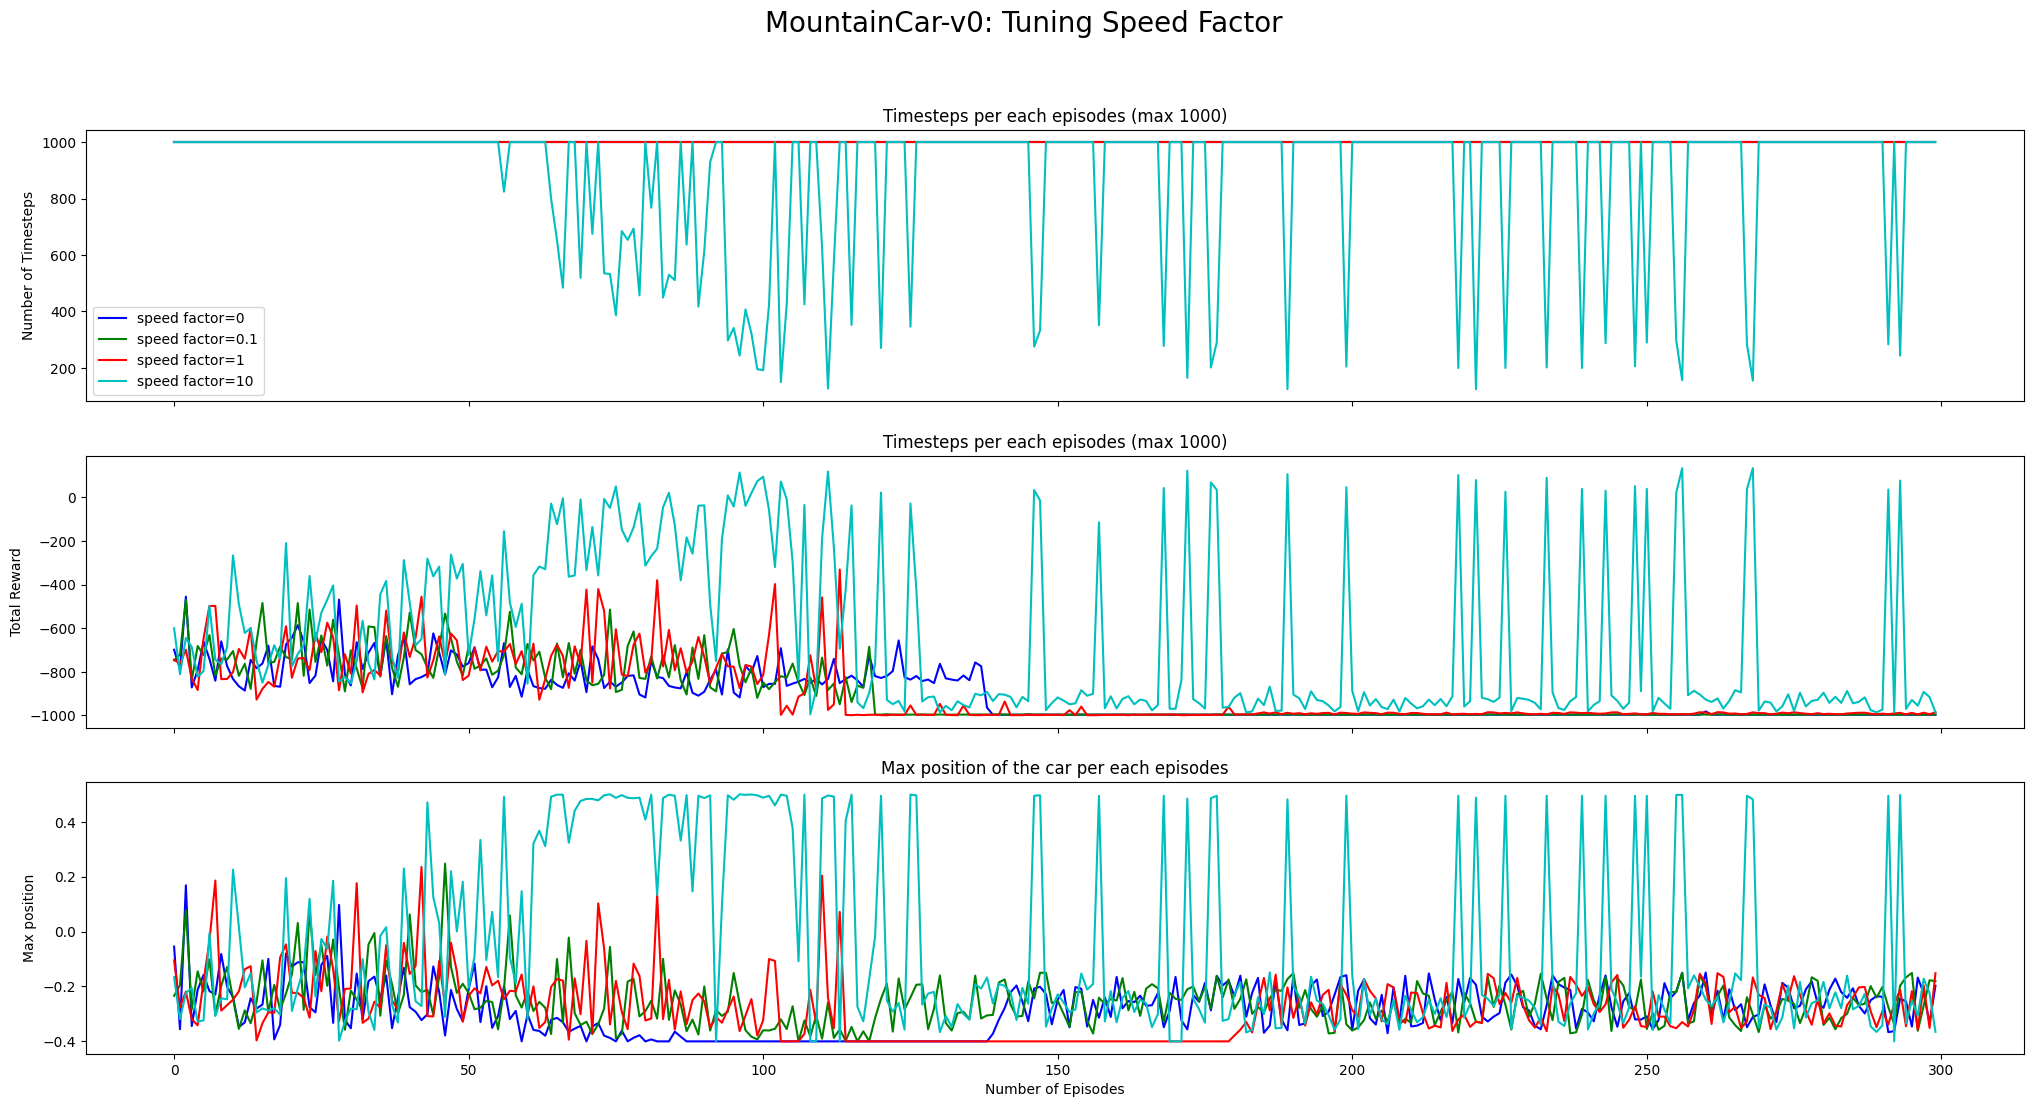

In [ ]:
ts=np.arange(num_episodes)
colors=['b','g','r','c','m']
fig, axes=plt.subplots(nrows=3,ncols=1,sharex="all",figsize=(25,12))

for i in range(len(different_speed_factor)):
  axes[0].plot(ts,episodes_ts[i],colors[i],label='speed factor='+str(different_speed_factor[i]))

for i in range(len(different_speed_factor)):
  axes[1].plot(ts,total_rw_ts[i],colors[i],label='speed factor=='+str(different_speed_factor[i]))

for i in range(len(different_speed_factor)):
  axes[2].plot(ts,maxpos_ts[i],colors[i],label='speed factor=='+str(different_speed_factor[i]))

fig.suptitle(r'MountainCar-v0: Tuning Speed Factor',fontsize=20)

axes[0].set_ylabel("Number of Timesteps")
axes[0].set_title("Timesteps per each episodes (max 1000)")
axes[0].legend()

axes[1].set_ylabel("Total Reward")
axes[1].set_title("Timesteps per each episodes (max 1000)")


axes[2].set_xlabel("Number of Episodes")
axes[2].set_ylabel("Max position")
axes[2].set_title("Max position of the car per each episodes")





##Mountain car Decaying T

In [ ]:
#estimated time, 4 hrs

#use lr=1e-5, gamma=0.5, Temperature=0.1, pos reward factor=0.1, neg reward factor=10, speed factor=10

num_episodes=500
episodes_ts=[]
total_rw_ts=[]
maxpos_ts=[]

for i in range(20):
  print("Trial: "+str(i))
  policy_net_decay=NeuralNet_decay_T(env.observation_space.shape[0],env.action_space.n,gamma=0.5,learning_rate=1e-5)
  reinforce=Reinforce_MC_decay_T(policy_net_decay_T=policy_net_decay,max_timestep=1000,T=0.1,T_decay_factor=0.95)
  ts_per_episodes, total_rw_per_episode, maxpos_per_episodes=reinforce.train(num_episodes,env,positive_reward_factor=0.1,negative_reward_factor=10,speed_factor=10)
  episodes_ts.append(np.array(ts_per_episodes))
  total_rw_ts.append(np.array(total_rw_per_episode))
  maxpos_ts.append(np.array(maxpos_per_episodes))

episodes_ts=np.array(episodes_ts) #50*1000
total_rw_ts=np.array(total_rw_ts) #50*1000
maxpos_ts=np.array(maxpos_ts) #50*1000
#episodes_ts=np.mean(episodes_ts,axis=0)


Text(0.5, 1.0, 'Average Max position of Agent per Episodes (Averaged over 20 trials)')

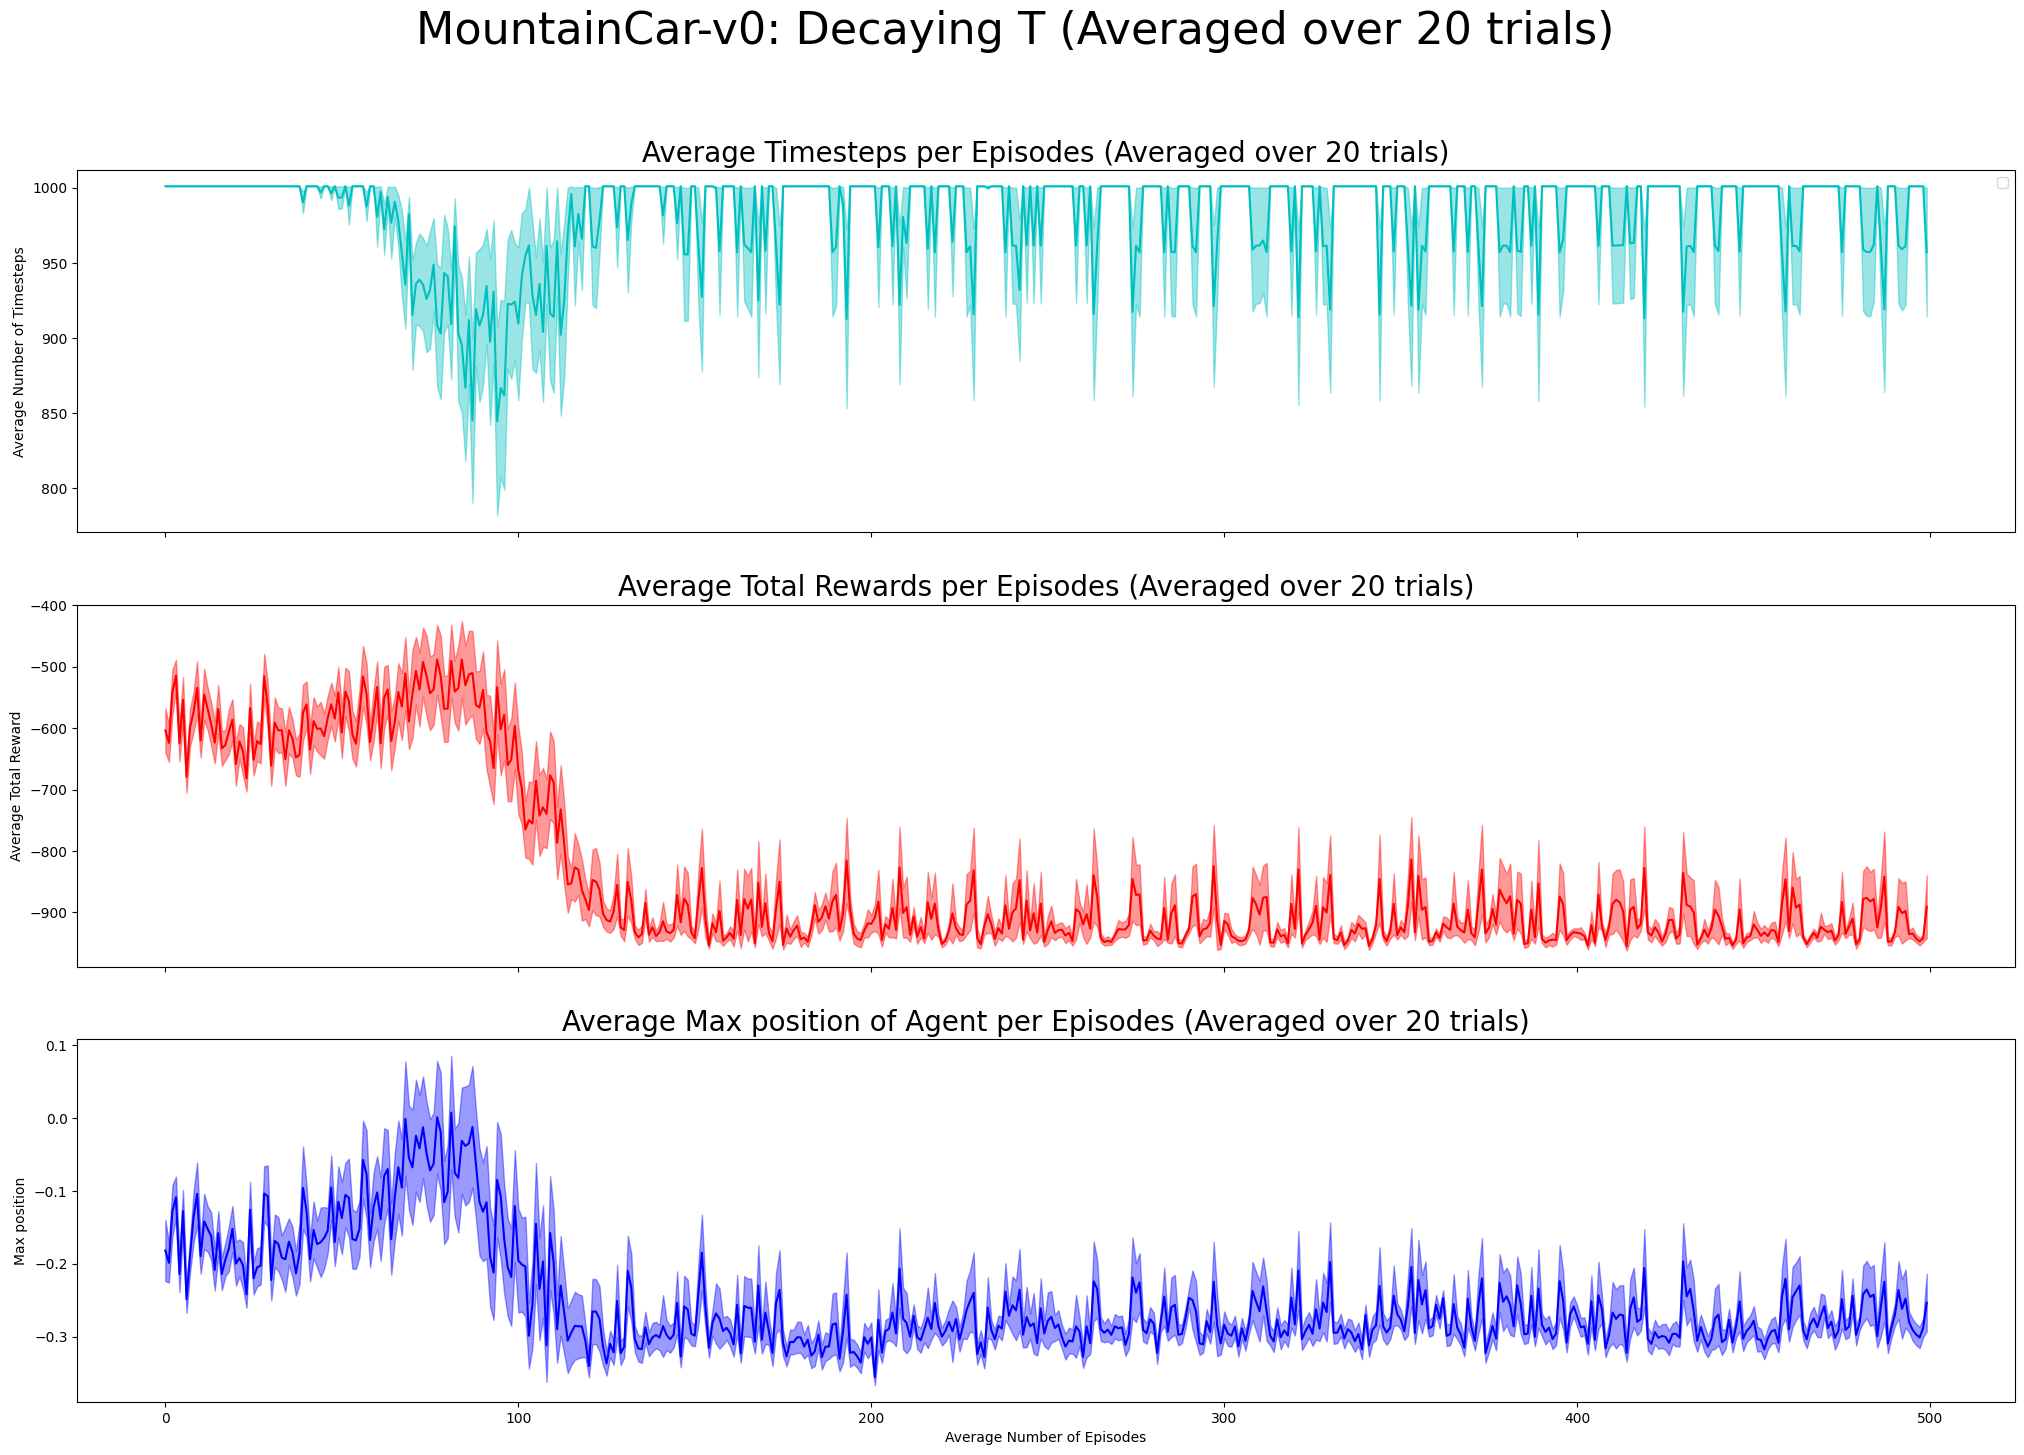

In [25]:
ts=np.arange(num_episodes)
colors=['b','g','r','c','m']
fig, axes=plt.subplots(nrows=3,ncols=1,sharex="all",figsize=(25,16))

avg_episodes_ts=np.mean(episodes_ts,axis=0)
avg_total_rw_ts=np.mean(total_rw_ts,axis=0)
avg_maxpos_ts=np.mean(maxpos_ts,axis=0)
#The plots should also include the interquantile range of the 50 independent runs.

axes[0].plot(ts,avg_episodes_ts,'c')
std_over_trials=np.std(episodes_ts,axis=0)/np.sqrt(np.size(episodes_ts,axis=0))
performance_below=avg_episodes_ts-std_over_trials
performance_above=avg_episodes_ts+std_over_trials
axes[0].fill_between(range(0,num_episodes),performance_below,performance_above,alpha=0.4,color='c')


axes[1].plot(ts,avg_total_rw_ts,'r')
std_over_trials=np.std(total_rw_ts,axis=0)/np.sqrt(np.size(total_rw_ts,axis=0))
performance_below=avg_total_rw_ts-std_over_trials
performance_above=avg_total_rw_ts+std_over_trials
axes[1].fill_between(range(0,num_episodes),performance_below,performance_above,alpha=0.4,color='r')


axes[2].plot(ts,avg_maxpos_ts,'b')
std_over_trials=np.std(maxpos_ts,axis=0)/np.sqrt(np.size(maxpos_ts,axis=0))
performance_below=avg_maxpos_ts-std_over_trials
performance_above=avg_maxpos_ts+std_over_trials
axes[2].fill_between(range(0,num_episodes),performance_below,performance_above,alpha=0.4,color='b')

fig.suptitle(r'MountainCar-v0: Decaying T (Averaged over 20 trials)',fontsize=32)

axes[0].set_ylabel("Average Number of Timesteps")
axes[0].set_title("Average Timesteps per Episodes (Averaged over 20 trials)",fontsize=20)
axes[0].legend()

axes[1].set_ylabel("Average Total Reward")
axes[1].set_title("Average Total Rewards per Episodes (Averaged over 20 trials)",fontsize=20)


axes[2].set_xlabel("Average Number of Episodes")
axes[2].set_ylabel("Max position")
axes[2].set_title("Average Max position of Agent per Episodes (Averaged over 20 trials)",fontsize=20)

##Mountain Car Fixed T

In [ ]:
#use pos reward factor=1, neg reward factor=1, speed factor=10 (from previuos observation), lr=3e-4
num_episodes=150 #usually start to observe some pattern after 100 episodes
episodes_ts=[]
total_rw_ts=[] #total rewards for 9 independent runs
maxpos_ts=[] #max pos over 9 independent runs
different_gamma=[0.1,0.5,0.99]
different_T=[0.1,1,10]

for i in range(len(different_gamma)):
  for j in range(len(different_T)):
    policy_net=NeuralNet(env.observation_space.shape[0],env.action_space.n,T=different_T[j], gamma=different_gamma[i])
    reinforce=Reinforce_MC(policy_net=policy_net,max_timestep=1000)
    ts_per_episodes, total_rw_per_episode, maxpos_per_episodes=reinforce.train(num_episodes,env,positive_reward_factor=1,negative_reward_factor=1,speed_factor=10)
    episodes_ts.append(np.array(ts_per_episodes))
    total_rw_ts.append(np.array(total_rw_per_episode))
    maxpos_ts.append(np.array(maxpos_per_episodes))


episodes_ts=np.array(episodes_ts) #will contain 9 indepent trials (one for each combination), each containing 300 episodes
total_rw_ts=np.array(total_rw_ts)
maxpos_ts=np.array(maxpos_ts)
#episodes_ts=np.mean(episodes_ts,axis=0)

Text(0.5, 1.0, 'Max position of the car per each episodes')

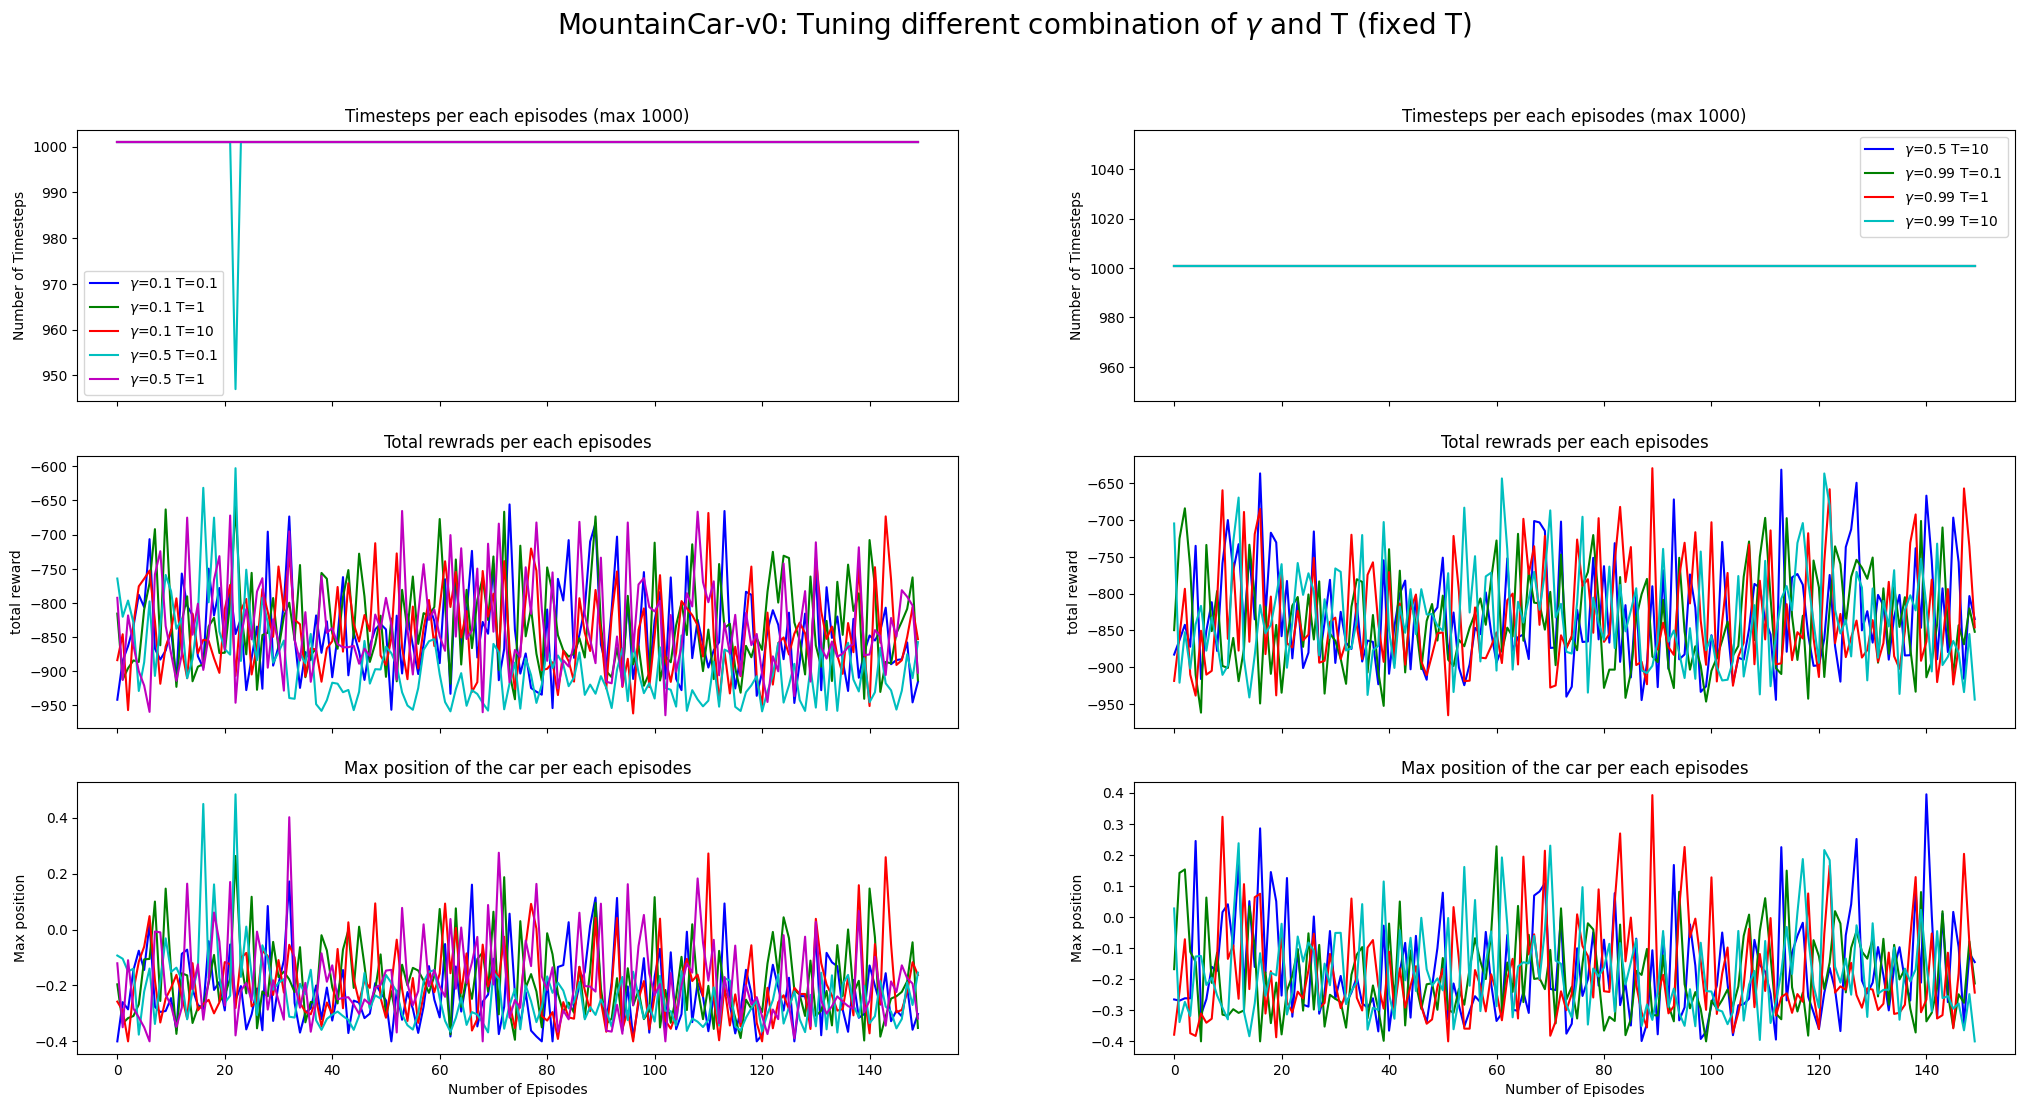

In [35]:
#plot result
ts=np.arange(num_episodes)
colors=['b','g','r','c','m','y']
fig, axes=plt.subplots(nrows=3,ncols=2,sharex="all",figsize=(25,12))


line_no=0
for i in range(len(different_gamma)):
  for j in range(len(different_T)):
    axes[0][line_no//5].plot(ts,episodes_ts[line_no],colors[line_no%5],label=r'$\gamma$='+str(different_gamma[i])+" T="+str(different_T[j]))
    axes[1][line_no//5].plot(ts,total_rw_ts[line_no],colors[line_no%5],label=r'$\gamma$='+str(different_gamma[i])+" T="+str(different_T[j]))
    axes[2][line_no//5].plot(ts,maxpos_ts[line_no],colors[line_no%5],label=r'$\gamma$='+str(different_gamma[i])+" T="+str(different_T[j]))
    line_no+=1

fig.suptitle(r'MountainCar-v0: Tuning different combination of $\gamma$ and T (fixed T)',fontsize=20)

axes[0][0].set_ylabel("Number of Timesteps")
axes[0][0].set_title("Timesteps per each episodes (max 1000)")
axes[0][0].legend()

axes[1][0].set_ylabel("total reward")
axes[1][0].set_title("Total rewrads per each episodes")

axes[2][0].set_xlabel("Number of Episodes")
axes[2][0].set_ylabel("Max position")
axes[2][0].set_title("Max position of the car per each episodes")

axes[0][1].set_ylabel("Number of Timesteps")
axes[0][1].set_title("Timesteps per each episodes (max 1000)")
axes[0][1].legend()

axes[1][1].set_ylabel("total reward")
axes[1][1].set_title("Total rewrads per each episodes")

axes[2][1].set_xlabel("Number of Episodes")
axes[2][1].set_ylabel("Max position")
axes[2][1].set_title("Max position of the car per each episodes")



#gamma=0.5 and T=10


##test different pos/neg factor

In [ ]:
#use gamma=0.5 T=10
num_episodes=150 #usually start to observe some pattern after 100 episodes
episodes_ts=[]
total_rw_ts=[] #total rewards for 9 independent runs
maxpos_ts=[] #max pos over 9 independent runs
different_psf=[0.1,1,10]
different_nrf=[0.1,1,10]

for i in range(len(different_psf)):
  for j in range(len(different_nrf)):
    policy_net=NeuralNet(env.observation_space.shape[0],env.action_space.n,T=10, gamma=0.5)
    reinforce=Reinforce_MC(policy_net=policy_net,max_timestep=1000)
    ts_per_episodes, total_rw_per_episode, maxpos_per_episodes=reinforce.train(num_episodes,env,positive_reward_factor=different_psf[i],negative_reward_factor=different_nrf[j],speed_factor=10)
    episodes_ts.append(np.array(ts_per_episodes))
    total_rw_ts.append(np.array(total_rw_per_episode))
    maxpos_ts.append(np.array(maxpos_per_episodes))


episodes_ts=np.array(episodes_ts) #will contain 9 indepent trials (one for each combination), each containing 300 episodes
total_rw_ts=np.array(total_rw_ts)
maxpos_ts=np.array(maxpos_ts)
#episodes_ts=np.mean(episodes_ts,axis=0)

Text(0.5, 1.0, 'Max position of the car per each episodes')

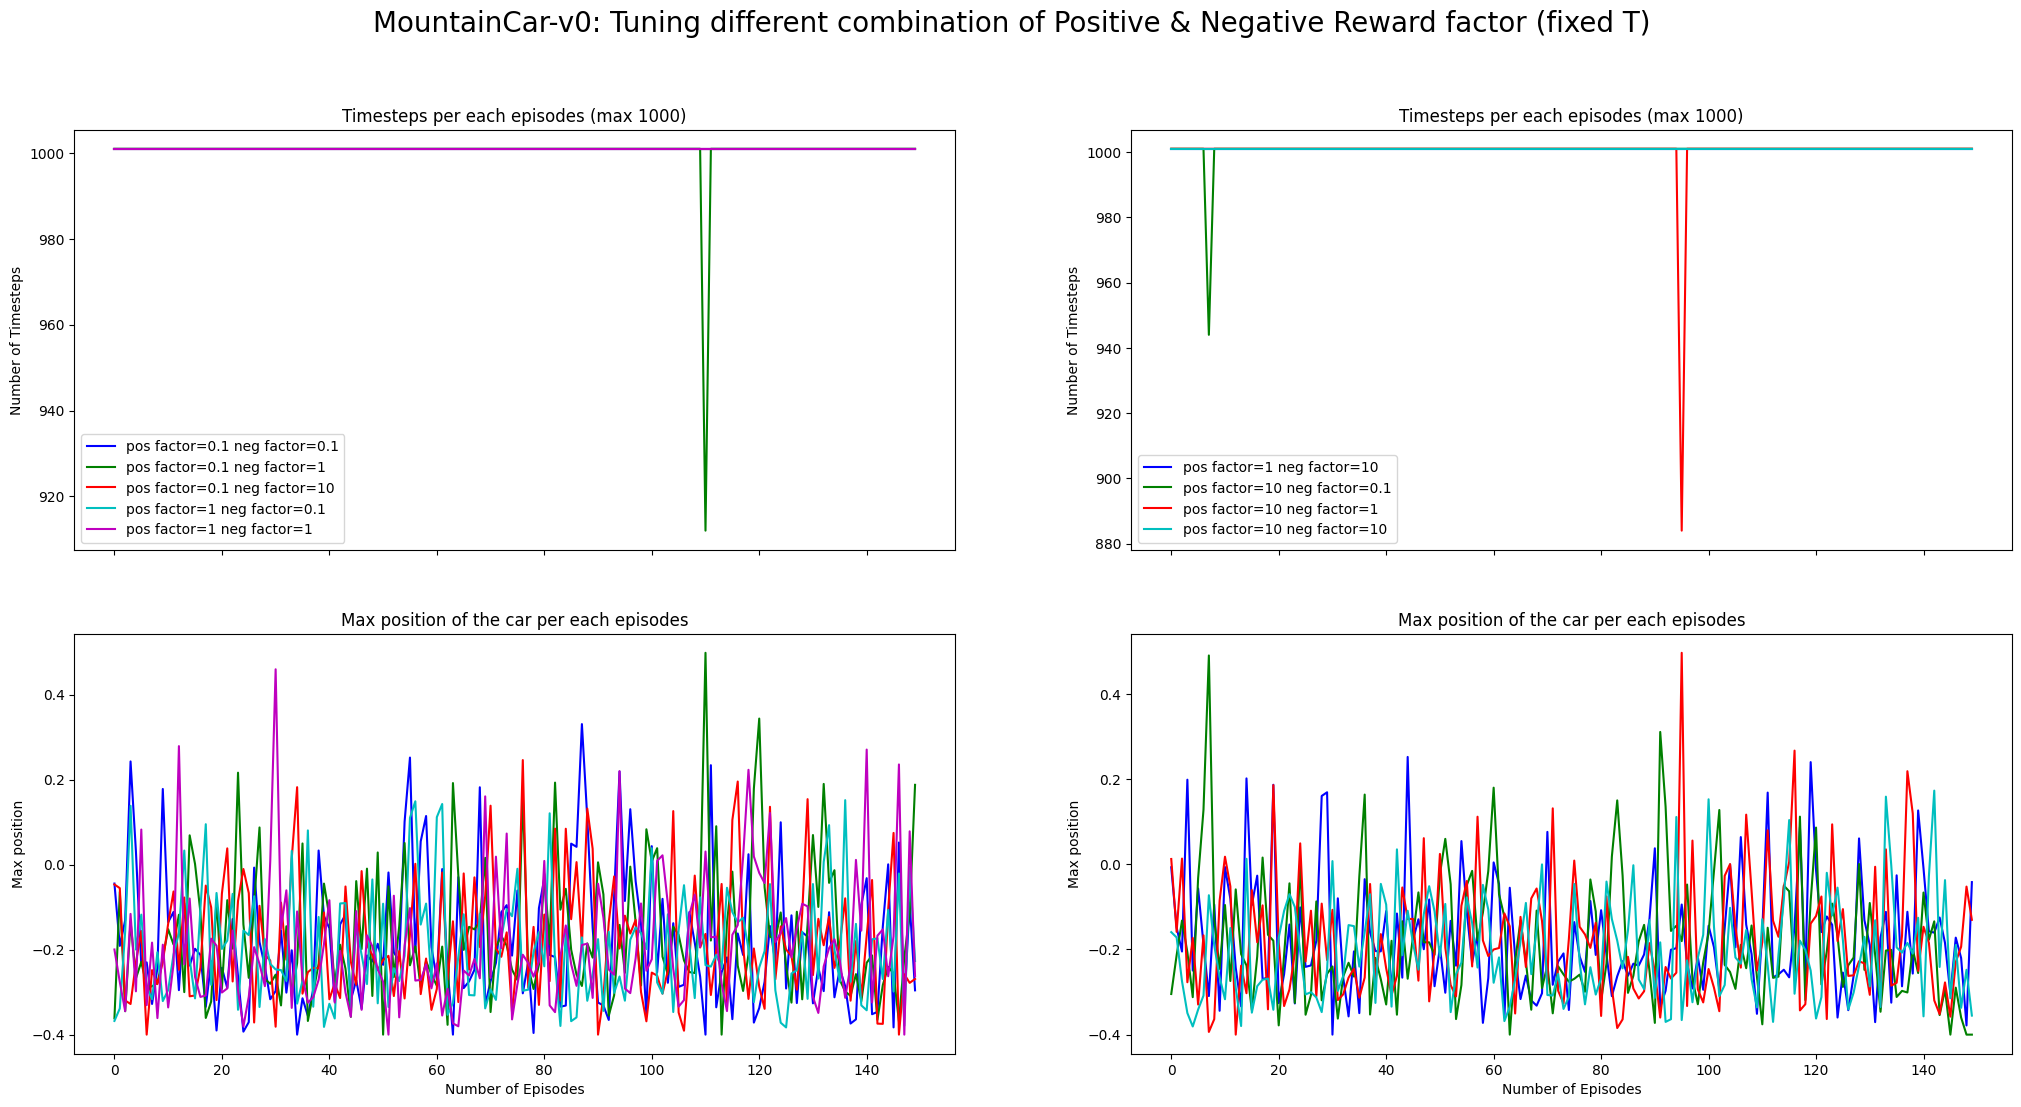

In [37]:

ts=np.arange(num_episodes)
colors=['b','g','r','c','m','y']
fig, axes=plt.subplots(nrows=2,ncols=2,sharex="all",figsize=(25,12))

line_no=0
for i in range(len(different_psf)):
  for j in range(len(different_nrf)):
    axes[0][line_no//5].plot(ts,episodes_ts[line_no],colors[line_no%5],label='pos factor='+str(different_psf[i])+" neg factor="+str(different_nrf[j]))
    #axes[1][line_no//5].plot(ts,total_rw_ts[line_no],colors[line_no%5],label='pos factor='+str(different_psf[i])+" neg factor="+str(different_nrf[j]))
    axes[1][line_no//5].plot(ts,maxpos_ts[line_no],colors[line_no%5],label='pos factor='+str(different_psf[i])+" neg factor="+str(different_nrf[j]))
    line_no+=1

fig.suptitle(r'MountainCar-v0: Tuning different combination of Positive & Negative Reward factor (fixed T)',fontsize=20)

axes[0][0].set_ylabel("Number of Timesteps")
axes[0][0].set_title("Timesteps per each episodes (max 1000)")
axes[0][0].legend()

axes[1][0].set_xlabel("Number of Episodes")
axes[1][0].set_ylabel("Max position")
axes[1][0].set_title("Max position of the car per each episodes")


axes[0][1].set_ylabel("Number of Timesteps")
axes[0][1].set_title("Timesteps per each episodes (max 1000)")
axes[0][1].legend()


axes[1][1].set_xlabel("Number of Episodes")
axes[1][1].set_ylabel("Max position")
axes[1][1].set_title("Max position of the car per each episodes")



#gamma=0.5 and T=0.99

#pos reward factor=0.1, neg reward factor=10


##Find optimal Learning Rate

In [ ]:
#tune lr
#use gamma=0.5 T=10, pos=0.1, neg=1
num_episodes=150 #usually start to observe some pattern after 100 episodes
episodes_ts=[]
total_rw_ts=[] #total rewards for 9 independent runs
maxpos_ts=[] #max pos over 9 independent runs
different_lr=[1e-5,1e-4,1e-3,1e-2]

for i in range(len(different_lr)):
  policy_net=NeuralNet(env.observation_space.shape[0],env.action_space.n,T=10, gamma=0.5,learning_rate=different_lr[i])
  reinforce=Reinforce_MC(policy_net=policy_net,max_timestep=1000)
  ts_per_episodes, total_rw_per_episode, maxpos_per_episodes=reinforce.train(num_episodes,env,positive_reward_factor=0.1,negative_reward_factor=1,speed_factor=10)
  episodes_ts.append(np.array(ts_per_episodes))
  total_rw_ts.append(np.array(total_rw_per_episode))
  maxpos_ts.append(np.array(maxpos_per_episodes))


episodes_ts=np.array(episodes_ts) #will contain 9 indepent trials (one for each combination), each containing 300 episodes
total_rw_ts=np.array(total_rw_ts)
maxpos_ts=np.array(maxpos_ts)
#episodes_ts=np.mean(episodes_ts,axis=0)

Text(0.5, 1.0, 'Max position of the car per each episodes')

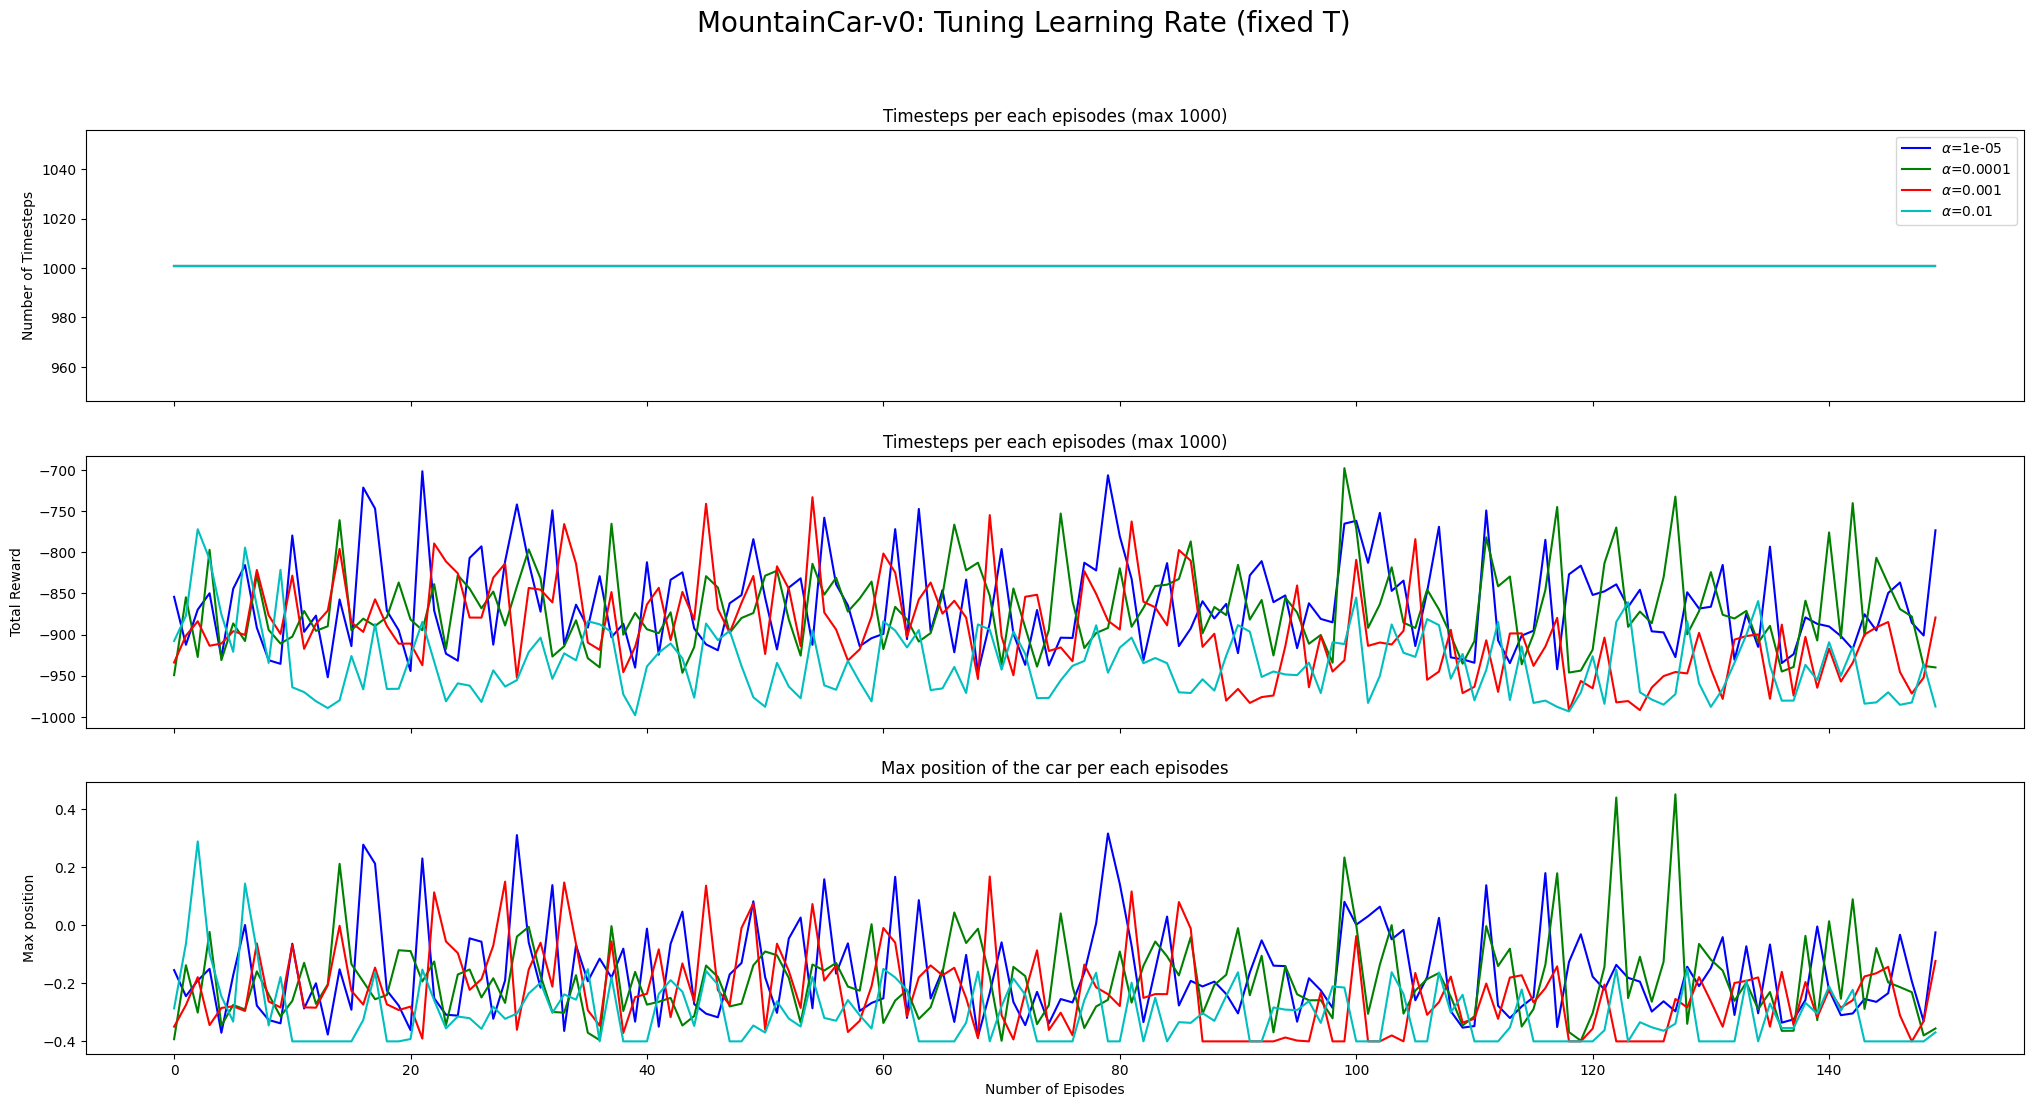

In [41]:
ts=np.arange(num_episodes)
colors=['b','g','r','c','m']
fig, axes=plt.subplots(nrows=3,ncols=1,sharex="all",figsize=(25,12))

for i in range(len(different_lr)):
  axes[0].plot(ts,episodes_ts[i],colors[i],label=r'$\alpha$='+str(different_lr[i]))

for i in range(len(different_lr)):
  axes[1].plot(ts,total_rw_ts[i],colors[i],label=r'$\alpha$='+str(different_lr[i]))

for i in range(len(different_lr)):
  axes[2].plot(ts,maxpos_ts[i],colors[i],label=r'$\alpha$='+str(different_lr[i]))

fig.suptitle(r'MountainCar-v0: Tuning Learning Rate (fixed T)',fontsize=20)

axes[0].set_ylabel("Number of Timesteps")
axes[0].set_title("Timesteps per each episodes (max 1000)")
axes[0].legend()

axes[1].set_ylabel("Total Reward")
axes[1].set_title("Timesteps per each episodes (max 1000)")


axes[2].set_xlabel("Number of Episodes")
axes[2].set_ylabel("Max position")
axes[2].set_title("Max position of the car per each episodes")





##Find Optimal Speed Factor

In [ ]:
#tune speed factor
#use gamma=0.5 T=10, pos=0.1, neg=1
num_episodes=150 #usually start to observe some pattern after 100 episodes
episodes_ts=[]
total_rw_ts=[] #total rewards for 9 independent runs
maxpos_ts=[] #max pos over 9 independent runs
different_speed_factor=[0,0.1,1,10]

for i in range(len(different_speed_factor)):
  policy_net=NeuralNet(env.observation_space.shape[0],env.action_space.n,T=10, gamma=0.5,learning_rate=1e-5)
  reinforce=Reinforce_MC(policy_net=policy_net,max_timestep=1000)
  ts_per_episodes, total_rw_per_episode, maxpos_per_episodes=reinforce.train(num_episodes,env,positive_reward_factor=0.1,negative_reward_factor=1,speed_factor=different_speed_factor[i])
  episodes_ts.append(np.array(ts_per_episodes))
  total_rw_ts.append(np.array(total_rw_per_episode))
  maxpos_ts.append(np.array(maxpos_per_episodes))


episodes_ts=np.array(episodes_ts) #will contain 9 indepent trials (one for each combination), each containing 300 episodes
total_rw_ts=np.array(total_rw_ts)
maxpos_ts=np.array(maxpos_ts)
#episodes_ts=np.mean(episodes_ts,axis=0)

Text(0.5, 1.0, 'Max position of the car per each episodes')

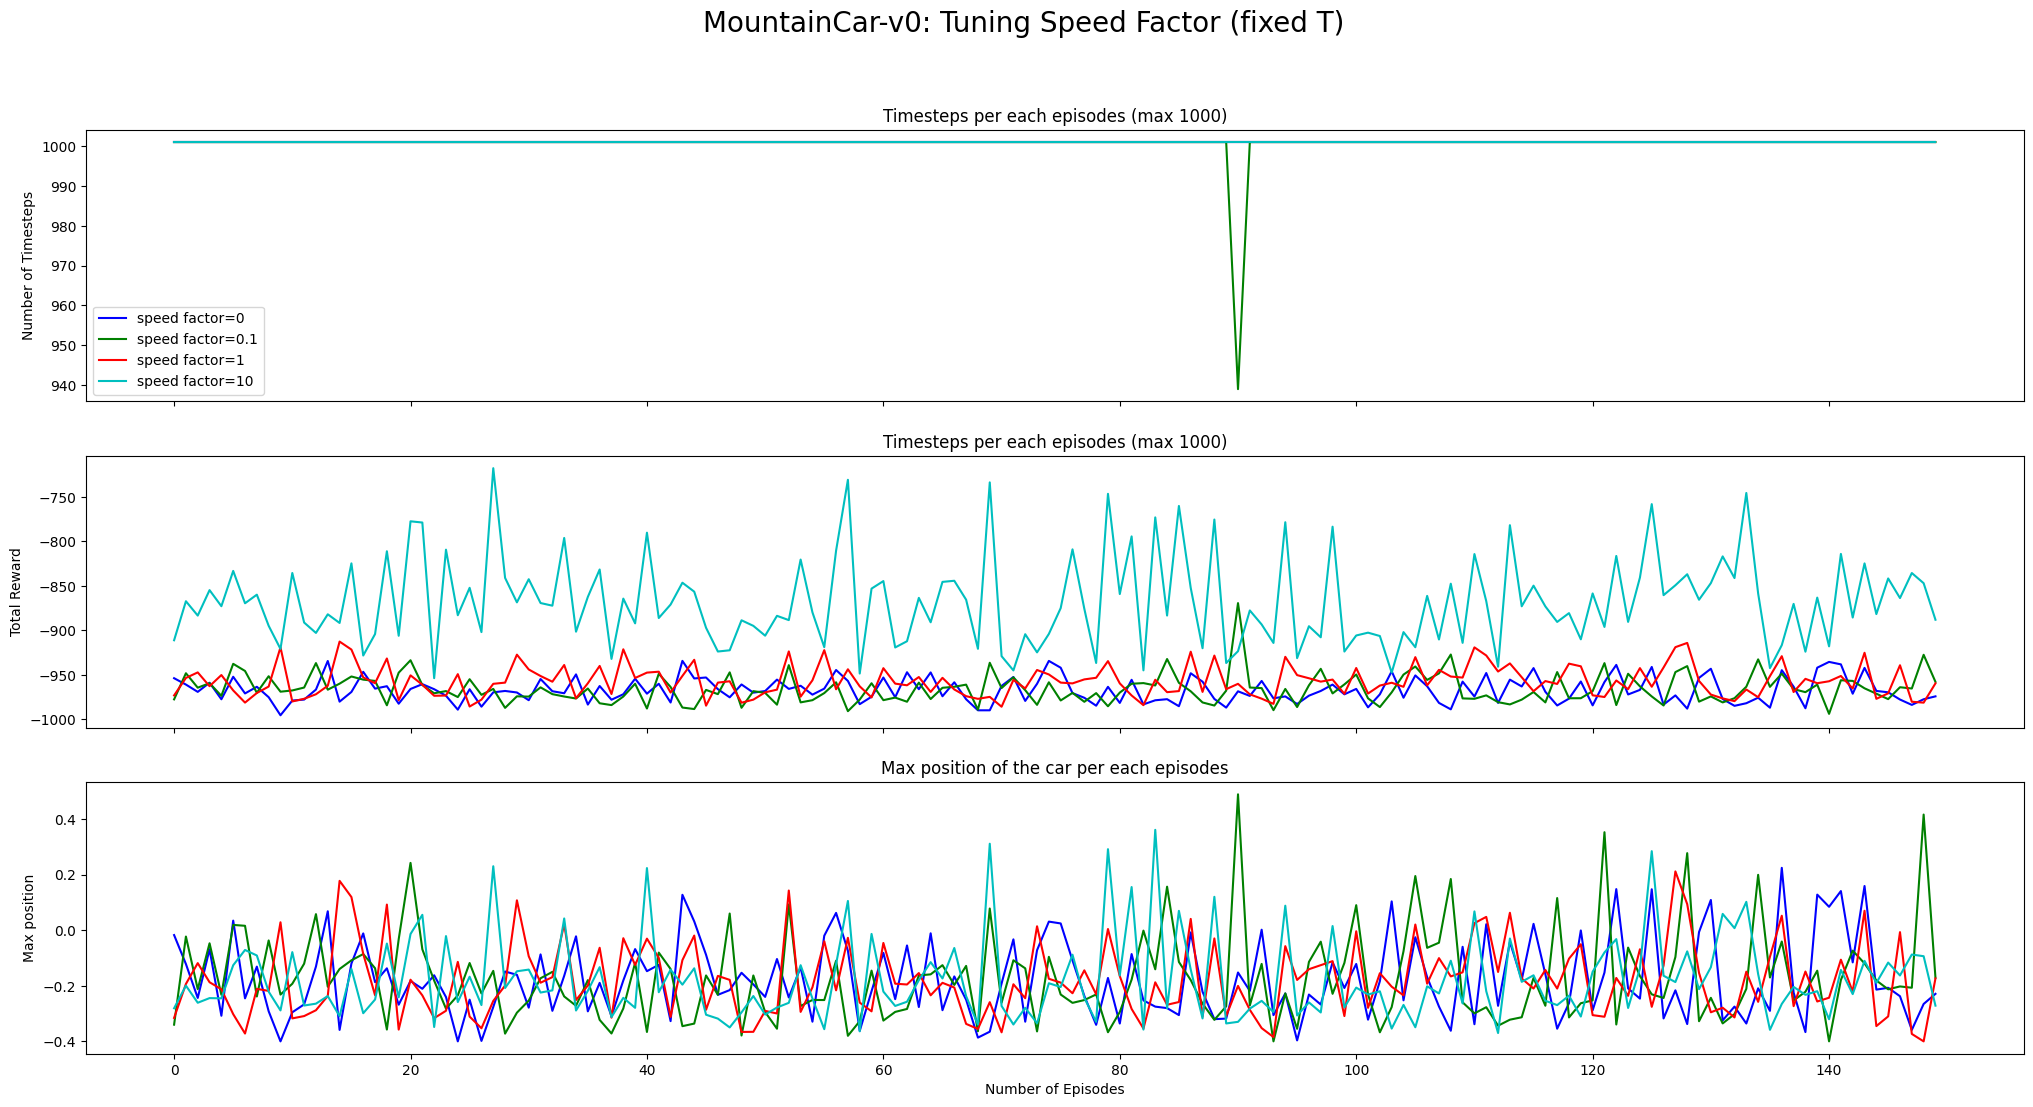

In [43]:
ts=np.arange(num_episodes)
colors=['b','g','r','c','m']
fig, axes=plt.subplots(nrows=3,ncols=1,sharex="all",figsize=(25,12))

for i in range(len(different_speed_factor)):
  axes[0].plot(ts,episodes_ts[i],colors[i],label='speed factor='+str(different_speed_factor[i]))

for i in range(len(different_speed_factor)):
  axes[1].plot(ts,total_rw_ts[i],colors[i],label='speed factor=='+str(different_speed_factor[i]))

for i in range(len(different_speed_factor)):
  axes[2].plot(ts,maxpos_ts[i],colors[i],label='speed factor=='+str(different_speed_factor[i]))

fig.suptitle(r'MountainCar-v0: Tuning Speed Factor (fixed T)',fontsize=20)

axes[0].set_ylabel("Number of Timesteps")
axes[0].set_title("Timesteps per each episodes (max 1000)")
axes[0].legend()

axes[1].set_ylabel("Total Reward")
axes[1].set_title("Timesteps per each episodes (max 1000)")

axes[2].set_xlabel("Number of Episodes")
axes[2].set_ylabel("Max position")
axes[2].set_title("Max position of the car per each episodes")





##Mountain car Fixed T

In [ ]:
#tune speed factor
#use gamma=0.5 T=10, pos=0.1, neg=1
num_episodes=500 #usually start to observe some pattern after 100 episodes
episodes_ts=[]
total_rw_ts=[] #total rewards for 9 independent runs
maxpos_ts=[] #max pos over 9 independent runs

for i in range(20):
  policy_net=NeuralNet(env.observation_space.shape[0],env.action_space.n,T=10, gamma=0.5,learning_rate=1e-5)
  reinforce=Reinforce_MC(policy_net=policy_net,max_timestep=1000)
  ts_per_episodes, total_rw_per_episode, maxpos_per_episodes=reinforce.train(num_episodes,env,positive_reward_factor=0.1,negative_reward_factor=1,speed_factor=10)
  episodes_ts.append(np.array(ts_per_episodes))
  total_rw_ts.append(np.array(total_rw_per_episode))
  maxpos_ts.append(np.array(maxpos_per_episodes))


episodes_ts=np.array(episodes_ts) #20*500
total_rw_ts=np.array(total_rw_ts)
maxpos_ts=np.array(maxpos_ts)
#episodes_ts=np.mean(episodes_ts,axis=0)

Text(0.5, 1.0, 'Average Max position of Agent per Episodes (Averaged over 20 trials)')

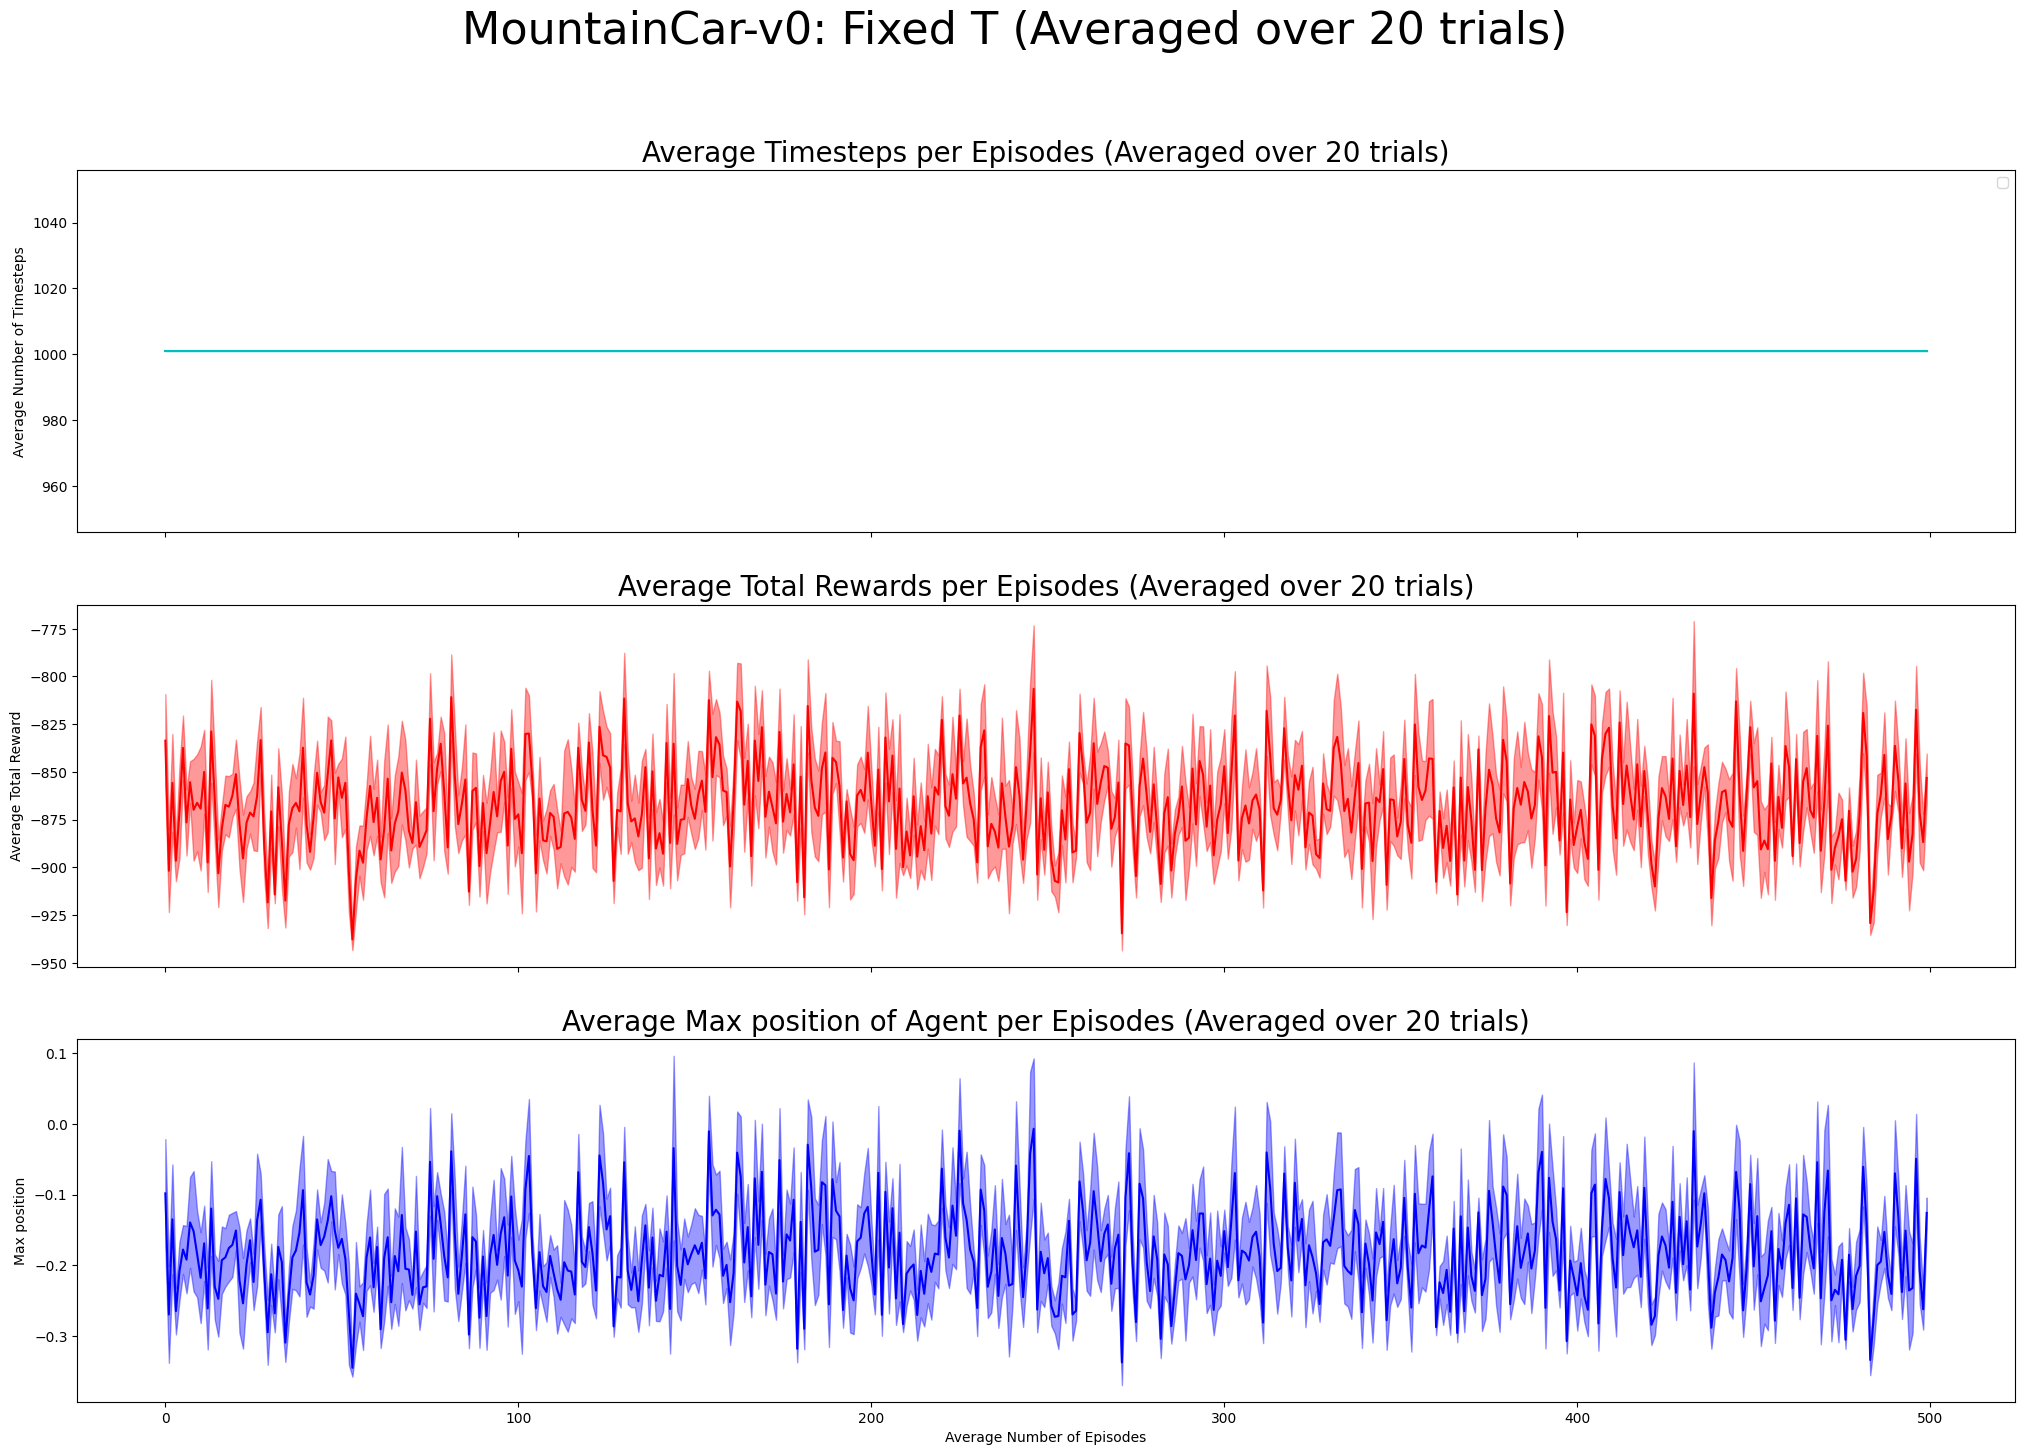

In [13]:
ts=np.arange(num_episodes)
colors=['b','g','r','c','m']
fig, axes=plt.subplots(nrows=3,ncols=1,sharex="all",figsize=(25,16))


avg_episodes_ts=np.mean(episodes_ts,axis=0)
avg_total_rw_ts=np.mean(total_rw_ts,axis=0)
avg_maxpos_ts=np.mean(maxpos_ts,axis=0)

axes[0].plot(ts,avg_episodes_ts,'c')
std_over_trials=np.std(episodes_ts,axis=0)/np.sqrt(np.size(episodes_ts,axis=0))
performance_below=avg_episodes_ts-std_over_trials
performance_above=avg_episodes_ts+std_over_trials
axes[0].fill_between(range(0,num_episodes),performance_below,performance_above,alpha=0.4,color='c')


axes[1].plot(ts,avg_total_rw_ts,'r')
std_over_trials=np.std(total_rw_ts,axis=0)/np.sqrt(np.size(total_rw_ts,axis=0))
performance_below=avg_total_rw_ts-std_over_trials
performance_above=avg_total_rw_ts+std_over_trials
axes[1].fill_between(range(0,num_episodes),performance_below,performance_above,alpha=0.4,color='r')


axes[2].plot(ts,avg_maxpos_ts,'b')
std_over_trials=np.std(maxpos_ts,axis=0)/np.sqrt(np.size(maxpos_ts,axis=0))
performance_below=avg_maxpos_ts-std_over_trials
performance_above=avg_maxpos_ts+std_over_trials
axes[2].fill_between(range(0,num_episodes),performance_below,performance_above,alpha=0.4,color='b')


fig.suptitle(r'MountainCar-v0: Fixed T (Averaged over 20 trials)',fontsize=32)

axes[0].set_ylabel("Average Number of Timesteps")
axes[0].set_title("Average Timesteps per Episodes (Averaged over 20 trials)",fontsize=20)
axes[0].legend()

axes[1].set_ylabel("Average Total Reward")
axes[1].set_title("Average Total Rewards per Episodes (Averaged over 20 trials)",fontsize=20)


axes[2].set_xlabel("Average Number of Episodes")
axes[2].set_ylabel("Max position")
axes[2].set_title("Average Max position of Agent per Episodes (Averaged over 20 trials)",fontsize=20)